In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import scipy.stats as st
from tqdm import tqdm
from math import gamma
from numba import njit
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from random import choices
import detection as dtc
import fitting
import emission
from constants import *
import cross_sections as cs
from numba import njit
from joblib import Parallel, delayed
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy import units as u
import datetime


Bad key text.latex.preview in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default qualit

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
# https://en.wikipedia.org/wiki/Neutrino_oscillation
theta_12 = 33.447*2*np.pi/360
theta_23 = 45*2*np.pi/360
theta_13 = 8.878*2*np.pi/360
delta_cp = 0#195*2*np.pi/360

c_12 = np.cos(theta_12)
c_13 = np.cos(theta_13)
c_23 = np.cos(theta_23)
s_12 = np.sin(theta_12)
s_13 = np.sin(theta_13)
s_23 = np.sin(theta_23)

U = np.array([[c_12*c_13, s_12*c_13, s_13*np.exp(-1j*delta_cp)],
             [-s_12*c_23-c_12*s_23*s_13*np.exp(1j*delta_cp), c_12*c_23-s_12*s_23*s_13*np.exp(1j*delta_cp), s_23*c_13],
             [s_12*s_23-c_12*c_23*s_13*np.exp(1j*delta_cp), -c_12*s_23-s_12*c_23*s_13*np.exp(1j*delta_cp), c_23*c_13]])

#delta_m = np.array([2.44e-3, 7.53e-5, 2.44e-3])
delta_m = {'m_10': 7.53e-2, 'm_20': 2.44, 'm_21': 2.44,
           'm_01': 7.53e-2, 'm_02': 2.44, 'm_12': 2.44} #eV²

# Neutrino oscillations in vaccum

## Decoherence

In [5]:
def osc_prob_3flavor(x, alpha: int, beta: int, delta_m: dict):
    # Kronecker delta
    if alpha == beta:
        delta = 1
    else:
        delta = 0
    # Sum over all mass states with i > j
    re_cos = 0
    im_sin = 0
    for i in range(3):
        for j in range(i):
            re_cos += (np.conj(U[alpha,i])*U[beta,i]*U[alpha,j]*np.conj(U[beta,j])).real*(1-np.cos(delta_m[f'm_{i}{j}']*x/2))
            im_sin += (np.conj(U[alpha,i])*U[beta,i]*U[alpha,j]*np.conj(U[beta,j])).imag*np.sin(delta_m[f'm_{i}{j}']*x/2)
    return delta - 2*re_cos + 2*im_sin

def osc_prob_3flavor_E_and_L(x, y, alpha: int, beta: int, delta_m: dict):
    # Kronecker delta
    if alpha == beta:
        delta = 1
    else:
        delta = 0
    # Sum over all mass states with i > j
    re_cos = 0
    im_sin = 0
    for i in range(3):
        for j in range(i):
            re_cos += (np.conj(U[alpha,i])*U[beta,i]*U[alpha,j]*np.conj(U[beta,j])).real*(1-np.cos(delta_m[f'm_{i}{j}']*x/(2*y)))
            im_sin += (np.conj(U[alpha,i])*U[beta,i]*U[alpha,j]*np.conj(U[beta,j])).imag*np.sin(delta_m[f'm_{i}{j}']*(x/2*y))
    return delta - 2*re_cos + 2*im_sin

def osc_prob_3flavor_fixed_E(x, E, alpha: int, beta: int, delta_m: dict):
    # Kronecker delta
    if alpha == beta:
        delta = 1
    else:
        delta = 0
    # Sum over all mass states with i > j
    re_cos = 0
    im_sin = 0
    for i in range(3):
        for j in range(i):
            re_cos += (np.conj(U[alpha,i])*U[beta,i]*U[alpha,j]*np.conj(U[beta,j])).real*(1-np.cos(delta_m[f'm_{i}{j}']*x / (2*E)))
            im_sin += (np.conj(U[alpha,i])*U[beta,i]*U[alpha,j]*np.conj(U[beta,j])).imag*np.sin(delta_m[f'm_{i}{j}']*x / (2*E))
    return delta - 2*re_cos + 2*im_sin

def osc_prob_3flavor_coh(x, E, alpha: int, beta: int, delta_m: dict, sigma_x):
    # Kronecker delta
    if alpha == beta:
        delta = 1
    else:
        delta = 0
    # Sum over all mass states with i > j
    re_cos = 0
    im_sin = 0
    for i in range(3):
        for j in range(i):
            L_coh = (4*np.sqrt(2)*sigma_x*E**2) / np.abs(delta_m[f'm_{i}{j}'])
            L_osc = (4*np.pi*E)/delta_m[f'm_{i}{j}']
            coh_term = np.exp(-(x/L_coh)**2)
            re_cos += (np.conj(U[alpha,i])*U[beta,i]*U[alpha,j]*np.conj(U[beta,j])).real*(1-np.cos(delta_m[f'm_{i}{j}']*x / (2*E))*coh_term)
            im_sin += (np.conj(U[alpha,i])*U[beta,i]*U[alpha,j]*np.conj(U[beta,j])).imag*np.sin(delta_m[f'm_{i}{j}']*x / (2*E))*coh_term
    return delta - 2*re_cos + 2*im_sin

def cos_ave(x, delta_m):
    sig = 0.2*x
    return np.cos(delta_m*x)*np.exp(-0.5*(delta_m*sig)**2)

def sin_ave(x, delta_m):
    sig = 0.2*x
    return np.sin(delta_m*x)*np.exp(-0.5*(delta_m*sig)**2)

def osc_prob_3flavor_ave(x, alpha, beta, delta_m):
    if alpha == beta:
        delta = 1
    else:
        delta = 0
    re_cos = 0
    im_sin = 0
    for i in range(3):
        for j in range(i):
            re_cos += (np.conj(U[alpha,i])*U[beta,i]*U[alpha,j]*np.conj(U[beta,j])).real*(1-cos_ave(x/2, delta_m[f'm_{i}{j}']))
            im_sin += (np.conj(U[alpha,i])*U[beta,i]*U[alpha,j]*np.conj(U[beta,j])).imag*sin_ave(x/2, delta_m[f'm_{i}{j}'])
    return delta - 2*re_cos + 2*im_sin

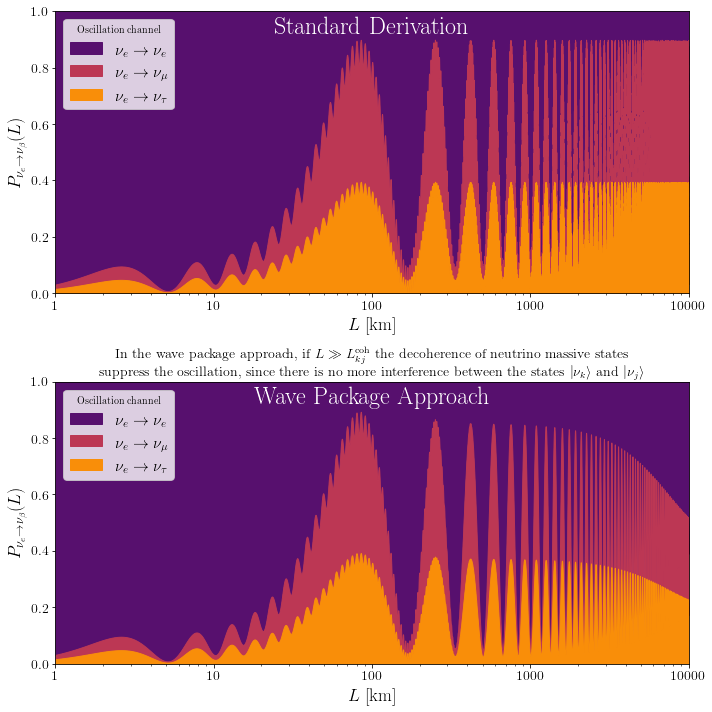

In [24]:
final = 4 # km
initial = 0 # km
x = np.logspace(initial, final, 100000)
E = 1 # eV
sigma = 100 # km
up_0 = osc_prob_3flavor_fixed_E(x, E, 0, 0, delta_m)+osc_prob_3flavor_fixed_E(x, E, 0, 1, delta_m)+osc_prob_3flavor_fixed_E(x, E, 0, 2, delta_m)
middle_0 = osc_prob_3flavor_fixed_E(x, E, 0, 1, delta_m)+osc_prob_3flavor_fixed_E(x, E, 0, 2, delta_m)
low_0 = osc_prob_3flavor_fixed_E(x, E, 0, 2, delta_m)
up_1 = osc_prob_3flavor_coh(x, E, 0, 0, delta_m, sigma)+osc_prob_3flavor_coh(x, E, 0, 1, delta_m, sigma)+osc_prob_3flavor_coh(x, E, 0, 2, delta_m, sigma)
middle_1 = osc_prob_3flavor_coh(x, E, 0, 1, delta_m, sigma)+osc_prob_3flavor_coh(x, E, 0, 2, delta_m, sigma)
low_1 = osc_prob_3flavor_coh(x, E, 0, 2, delta_m, sigma)
palette = 'inferno'

fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].fill_between(x, middle_0, up_0, color = sns.color_palette(palette, 3)[0],
         label = r'$\nu_e \rightarrow \nu_e$')
ax[0].fill_between(x, low_0, middle_0, color = sns.color_palette(palette, 3)[1],
         label = r'$\nu_e \rightarrow \nu_\mu$')
ax[0].fill_between(x, 0, low_0, color = sns.color_palette(palette, 3)[2],
         label = r'$\nu_e \rightarrow \nu_\tau$')

ax[1].fill_between(x, middle_1, up_1, color = sns.color_palette(palette, 3)[0], label = r'$\nu_e \rightarrow \nu_e$')
ax[1].fill_between(x, low_1, middle_1, color = sns.color_palette(palette, 3)[1], label = r'$\nu_e \rightarrow \nu_\mu$')
ax[1].fill_between(x, 0, low_1, color = sns.color_palette(palette, 3)[2], label = r'$\nu_e \rightarrow \nu_\tau$')
ax[0].set_xscale('log')
ax[0].set_xlabel(r'$L$ [km]', fontsize = 18)
ax[0].set_ylabel(r'$P_{\nu_e \rightarrow \nu_\beta}(L)$', fontsize = 18)
ax[0].set_ylim(0,1)
ax[0].set_xlim(10**initial, 10**final)
ax[0].legend(title='Oscillation channel', loc = 'upper left', fontsize = 16)
ax[0].text(1e2, 0.92, 'Standard Derivation', fontsize = 24, color = 'white', ha = 'center')
ax[0].set_yticklabels([f'{ax[0].get_yticks()[i]:.1f}' for i in range(len(ax[0].get_yticks()))],
                      fontsize=14)
ax[0].set_xticklabels([f'{int(ax[0].get_xticks()[i])}' for i in range(len(ax[0].get_xticks()))],
                      fontsize=14)

ax[1].set_xscale('log')
ax[1].set_xlabel(r'$L$ [km]', fontsize = 18)
ax[1].set_ylabel(r'$P_{\nu_e \rightarrow \nu_\beta}(L)$', fontsize = 18)
ax[1].set_ylim(0,1)
ax[1].set_xlim(10**initial, 10**final)
ax[1].legend(title='Oscillation channel', loc = 'upper left', fontsize = 16)
ax[1].text(1e2, 0.92, 'Wave Package Approach', fontsize = 24, color = 'white',
           ha = 'center')
ax[1].set_title(r'In the wave package approach, if $L \gg L_{kj}^{\mathrm{coh}}$ the decoherence of neutrino massive states'
'\n'
r'suppress the oscillation, since there is no more interference between the states $\left| \nu_k \right \rangle$ and $\left| \nu_j \right \rangle$',
                fontsize = 14)
ax[1].set_yticklabels([f'{ax[1].get_yticks()[i]:.1f}' for i in range(len(ax[1].get_yticks()))],
                      fontsize=14)
ax[1].set_xticklabels([f'{int(ax[1].get_xticks()[i])}' for i in range(len(ax[1].get_xticks()))],
                      fontsize=14)

plt.tight_layout()
fig.patch.set_alpha(0.2)
for ax in fig.axes:
    ax.patch.set_alpha(1)
plt.savefig('neutrino_osc_3flavor_coh.png', dpi = 300,
            bbox_inches = 'tight')

# Neutrino oscillations in matter

## 2 neutrinos

In [4]:
def m_tilde(n_e, E, G_F, delta_m, theta):
    A = np.sqrt(2)*2*G_F*E*n_e
    n_e_crit = delta_m*np.cos(2*theta)/(2*np.sqrt(2)*G_F*E)
    m_1 = A/2 - 0.5*np.sqrt((A - delta_m * np.cos(2*theta))**2 + delta_m**2 * np.sin(2*theta)**2)
    m_2 = A/2 + 0.5*np.sqrt((A - delta_m * np.cos(2*theta))**2 + delta_m**2 * np.sin(2*theta)**2)
    return m_1, m_2, n_e_crit

In [5]:
n_e = np.linspace(0, 1, 1000)

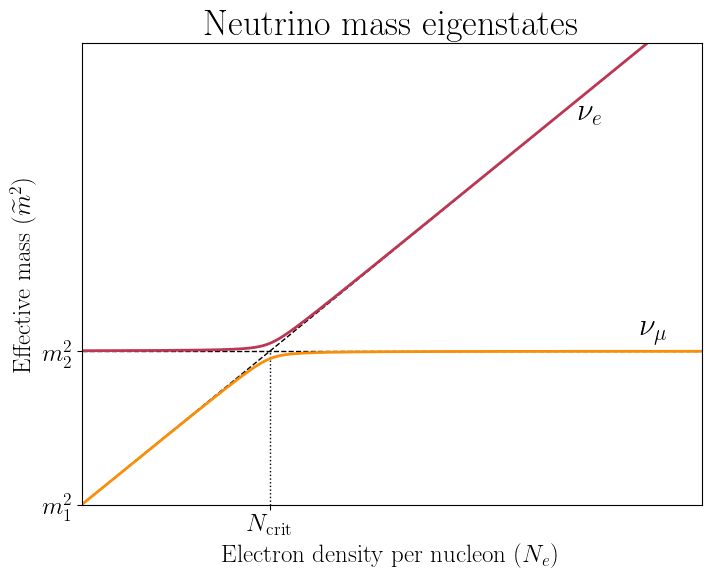

In [12]:
delta_m = 5e-6
G_F = 1.16e-5
E = 0.5
theta = 0.05

fig = plt.figure(figsize=(8,6))
plt.vlines(m_tilde(n_e, E, G_F, delta_m, theta)[2], m_tilde(n_e, E, G_F, delta_m, theta)[0][0],
           m_tilde(n_e, E, G_F, delta_m, theta)[1][0], ls = 'dotted', lw = 1, color = 'black')
plt.hlines(m_tilde(n_e, E, G_F, delta_m, theta)[1][0], 0, n_e[-1], lw = 1, ls = '--', color = 'black')
plt.plot([n_e[0], n_e[-1]],
         [m_tilde(n_e, E, G_F, delta_m, theta)[0][0], m_tilde(n_e, E, G_F, delta_m, theta)[1][-1]],
         lw = 1, ls = '--', color = 'black')
plt.plot(n_e, m_tilde(n_e, E, G_F, delta_m, theta)[0], color = sns.color_palette('inferno', 7)[5],
        lw = 2)
plt.plot(n_e, m_tilde(n_e, E, G_F, delta_m, theta)[1], color = sns.color_palette('inferno', 7)[3],
        lw = 2)
plt.ylim(m_tilde(n_e, E, G_F, delta_m, theta)[0][0], 1.25e-5)
plt.xlim(0, n_e[-1])
plt.xlabel(r'Electron density per nucleon ($N_e$)', fontsize = 18)
plt.ylabel(r'Effective mass ($\widetilde{m}^2$)', fontsize = 18)
plt.xticks([m_tilde(n_e, E, G_F, delta_m, theta)[2]], labels = [r'$N_{\mathrm{crit}}$'],
          fontsize = 18)
plt.yticks([m_tilde(n_e, E, G_F, delta_m, theta)[1][0], m_tilde(n_e, E, G_F, delta_m, theta)[0][0]],
           labels = [r'$m_2^2$', r'$m_1^2$'], fontsize = 18)
plt.text(0.9, 0.3e-5, r'$\nu_\mu$', fontsize = 22)
plt.text(0.8, 1e-5, r'$\nu_e$', fontsize = 22)
plt.title('Neutrino mass eigenstates', fontsize = 22)
fig.patch.set_alpha(1)
# plt.savefig('/home/pedroc/Documentos/pedro/Neutrino Oscillations/2_flavor_matter_resonance.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [61]:
delta_m = 5e-6
G_F = 1.16e-5
E = 0.5
theta = 0.035

In [17]:
np.arcsin(np.sqrt(0.005))/2

0.0353848683311068

In [55]:
def survival_prob(n_e, dn_edr, theta, E, G_F, delta_m):
    A = np.sqrt(2)*2*E*G_F*n_e
    cos_tilde = (-A/delta_m + np.cos(2*theta))/np.sqrt((A/delta_m - np.cos(2*theta))**2 + np.sin(2*theta)**2)
    sin_tilde = np.sin(2*theta)/np.sqrt((A/delta_m - np.cos(2*theta))**2 + np.sin(2*theta)**2)
    gamma = (delta_m*(np.sin(2*theta)**2)*n_e)/(2*E*np.cos(2*theta)*dn_edr)
    P_f = np.exp(-np.pi*gamma/2)
    return 0.5 + (0.5 - P_f)*np.cos(2*theta)*cos_tilde

In [57]:
r_sun = 696340
r = np.linspace(0.01, r_sun, 10000)
n_e = 245*np.exp(-10.54*r/r_sun)
dn_edr = np.diff(n_e)

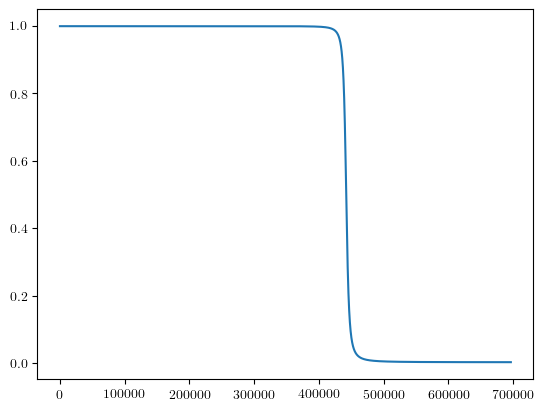

In [62]:
plt.plot(r[1:], survival_prob(n_e[1:], dn_edr, theta, E, G_F, delta_m))
# plt.plot(r, n_e)
# plt.xscale('log')
plt.show()

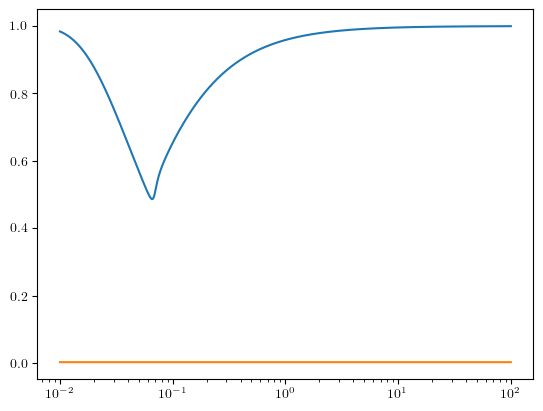

In [52]:
E = np.logspace(-2, 2, 10000)
plt.plot(E, survival_prob(2.2, 1e-6, theta, E, G_F, delta_m))
plt.plot(E, survival_prob(0, 1e-9, theta, E, G_F, delta_m))
plt.xscale('log')
plt.show()

In [5]:
def profile(r, Y_e):
    return (2e4*(r/1e9)**(-3))/Y_e

In [6]:
np.where((profile(r, 0.5) <= 1e4) & (profile(r, 0.5) >= 1e3))

(array([933390, 933391, 933392, ..., 961165, 961166, 961167]),)

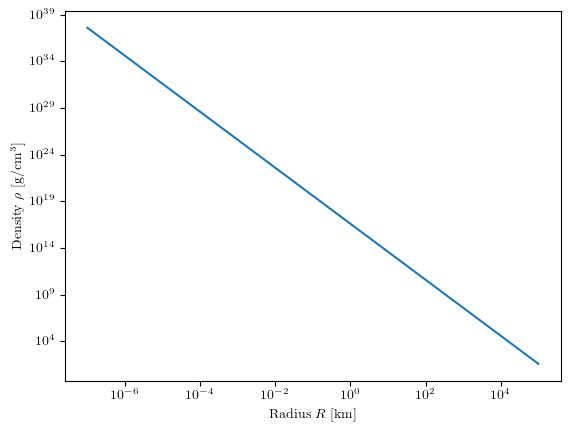

In [7]:
r = np.logspace(-2, 10, 1000000)

plt.plot(r/1e5, profile(r, 0.5))
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'Density $\rho$ [g/cm$^3$]')
plt.xlabel('Radius $R$ [km]')
# plt.xlim(-10, 1e4)
plt.show()

# Neutrino oscillations in Earth

## Only mantle

In [4]:
R_earth = 6400 # km
phi = np.linspace(0, 32*np.pi/180, 1000)
E = np.linspace(0, 70, 10000) # MeV
delta_m = 7.54e-5 # eV^2
theta_12 = 33.447*np.pi/180
G_F = 1.16e-5
N_e = 0.468
A = 2*np.sqrt(2)*G_F*E*N_e
thetam_12 = np.arcsin(np.sin(2*theta_12)/np.sqrt((A/delta_m - np.cos(2*theta_12))**2 + np.sin(2*theta_12)**2))/2

In [64]:
def prob(E, phi):
    L = R_earth*np.sqrt(2*(1 + np.cos(2*phi))) # km
    P_2e = np.sin(theta_12)**2 + np.sin(2*thetam_12)*np.sin(thetam_12 - theta_12)*np.sin(delta_m*np.sin(2*theta_12)*L/(4*E*np.sin(2*thetam_12)))**2
    return P_2e

In [65]:
probs = np.zeros((len(E), len(phi)))

for i in tqdm(range(len(E))):
    for j in range(len(phi)):
        probs[i,j] = prob(E[i], phi[j])

100%|██████████| 1000/1000 [00:10<00:00, 99.15it/s]


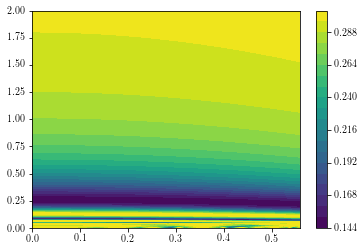

In [66]:
plt.contourf(phi, E, probs, levels = 20)
plt.colorbar()

(0.0, 0.3)

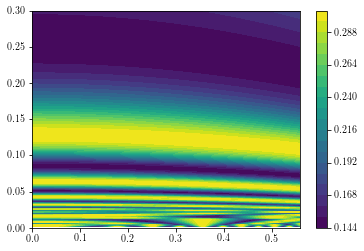

In [68]:
plt.contourf(phi, E, probs, levels = 20)
plt.colorbar()
plt.ylim(0, 0.3)

In [72]:
def produced_spectrum(x, specie, E_tot):
    if specie == 'nu_e':
        alpha = 2.92
        E_mean = 10.01
    elif specie == 'nubar_e':
        alpha = 2.61
        E_mean = 12.28
    elif specie == 'nu_x':
        alpha = 2.34
        E_mean = 12.31
    else:
        raise ValueError('Invalid entry for neutrino species. Please use "nu_e" for \
                electron neutrinos, "nubar_e" for electron antineutrinos or "nu_x" for mu or \
                tau (anti)neutrinos')
    A = (E_tot/3)*((1+alpha)**(1+alpha))/((gamma(1+alpha))*E_mean**(2+alpha))
    f_nu = A*(x**alpha)*np.exp(-(alpha + 1)*x/E_mean)
    return f_nu

In [87]:
def emitted_spectrum(x, flavor, E_tot, phi):
    F_e = produced_spectrum(x, 'nu_e', E_tot)
    F_ebar = produced_spectrum(x, 'nubar_e', E_tot)
    F_x = produced_spectrum(x, 'nu_x', E_tot)
    L = R_earth*np.sqrt(2*(1 - np.cos(2*phi))) # km
    y = 12.5/x
    if flavor == 'nu_e':
        return F_e*np.sin(theta_12)**2 + F_x*np.cos(theta_12)**2 + (F_e - F_x)*np.sin(2*thetam_12 - 2*theta_12)*np.sin(delta_m*np.sin(2*theta_12)*L*y/(1e-5*1e3*np.sin(2*thetam_12)))
    elif flavor == 'nubar_e':
        return a_ebar*F_e + b_ebar*F_ebar + c_ebar*F_x
    elif flavor == 'nu_x':
        return F_x
    else:
        raise ValueError('Invalid entry for neutrino species. Please use "nu_e" for \
                electron neutrinos, "nubar_e" for electron antineutrinos or "nu_x" for mu or \
                tau (anti)neutrinos')

In [238]:
phi = np.linspace(0, 58*np.pi/180, 200)

for i in tqdm(range(len(phi))):
# i = -1
    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(E, produced_spectrum(E, 'nu_e', 2e53), lw = 3, color = 'teal', ls = '--',
            label = 'No oscillation')
    plt.plot(E, emitted_spectrum(E, 'nu_e', 2e53, phi[i]), lw = 3, color = 'crimson',
            label = 'Star + Earth oscillation')
    center_x = 50
    center_y = 4e50
    circ1 = mpl.patches.Ellipse((center_x, center_y), 8, 1.33e50, fill = True, color = sns.color_palette('inferno')[2])
    circ2 = mpl.patches.Ellipse((center_x, center_y), 4, 0.66e50, fill = True, color = sns.color_palette('inferno')[4])
    ax.add_patch(circ1)
    ax.add_patch(circ2)
    plt.plot([center_x+8*np.cos(phi[i]),center_x], [4.65e50-1.3e50*np.sin(phi[i]), 4.65e50],
             lw = 1.5, ls = '--', color = 'black')
    plt.xlim(0, 60)
    plt.ylim(0, 6e50)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    ax.yaxis.offsetText.set_fontsize(14)
    plt.xlabel('Neutrino energy [MeV]', fontsize = 20)
    plt.ylabel('Time-integrated flux', fontsize = 20)
    plt.title(r'$\nu_e$ spectrum with Nadir angle: {:.2f}º'.format(phi[i]*180/np.pi), fontsize = 20)
    plt.text(50, 3.45e50, 'Mantle', fontsize = 14, ha = 'center', color = 'white')
    plt.text(50, 3.95e50, 'Core', fontsize = 14, ha = 'center')
    plt.text(50, 2.9e50, 'Neutrino direction', fontsize = 16, ha = 'center')
    plt.legend(loc = 'upper right', fontsize = 16)
    fig.patch.set_alpha(1)
    plt.savefig(f'/home/pedroc/Documentos/pedro/Mestradives/Simulations/Gifs/Earth_matter_effect_{i}.png',
                dpi = 300, bbox_inches = 'tight')
    plt.close()

100%|██████████| 200/200 [04:00<00:00,  1.20s/it]


## Mantle and core

The antineutrino electron spectrum at Earth due to MSW effect inside the Star and inside Earth, considering two layers of Earth is given by [[1](https://doi.org/10.1088/1475-7516/2004/01/004)]

\begin{align}
    \label{eq:flux} \tag{1}
    F_{\overline{\nu}_e}^D = \underbrace{\sin^2(\theta_{12}) F_x^0 + \cos^2(\theta_{12}) F_{\overline{\nu}_e}^0}_{\text{Star}} + \overbrace{\Delta F^0 \sum_{i=1}^7 A_i \sin^2\left(\frac{\sigma_i}{2} \right)}^{\text{Earth}}
\end{align}

where $\Delta F^0 = F_{\overline{\nu}_e}^0 - F_{\nu_x}^0$ and both $A_i$ and $\sigma_i$ are given in terms of the neutrino mixing angle $\theta_{12}$ and the effective mixing angle in the mantle $\theta_m$ and the core $\theta_c$ (see table 2 in ref [[1](https://doi.org/10.1088/1475-7516/2004/01/004)])

\begin{align}
    \label{eq:theta_matter} \tag{2}
    \sin^2(2 \theta_{m(c)}) = \frac{\sin^2(2 \theta_{12})}{\sin^2(2 \theta_{12}) + \left[\cos(2 \theta_{12}) - 2E V_{m(c)}/\Delta m^2 \right]^2}
\end{align}

ande $V_{m(c)}$ is the effective matter potential in the mantle (core) $V_{m(c)} = 2 \sqrt{2} G_F E N_e^{m(c)}$. The electron number density in the Mantle and the Core is $N_e^m = 2.2$ cm$^{-3}$ and $N_e^c = 5.4$ cm$^{-3}$, respectively [[2](https://doi.org/10.1016/S0370-2693(02)01358-8)]

**References**

1. Dighe, A. S., Kachelriess, M., Raffelt, G. G., & Tomas, R. (2004). Signatures of supernova neutrino oscillations in the earth mantle and core. Journal of Cosmology and Astroparticle Physics, 2004(01), 004. [https://doi.org/10.1088/1475-7516/2004/01/004](https://doi.org/10.1088/1475-7516/2004/01/004)

2. Bernabeu, J., Palomares-Ruiz, S., Perez, A., & Petcov, S. T. (2002). The earth Mantle-Core effect in charge-asymmetries for atmospheric neutrino oscillations. Physics Letters B, 531(1-2), 90-98. [https://doi.org/10.1016/S0370-2693(02)01358-8](https://doi.org/10.1016/S0370-2693(02)01358-8)

3. Borriello, E., Chakraborty, S., Mirizzi, A., Serpico, P. D., & Tamborra, I. (2012). Can one observe Earth matter effects with supernova neutrinos?. Physical Review D, 86(8), 083004. [https://doi.org/10.1103/PhysRevD.86.083004](https://doi.org/10.1103/PhysRevD.86.083004)

In [8]:
R_earth = 6371 # Km
R_core = 3486 # Km
phi = np.linspace(0, np.pi/2, 2000)
E = np.linspace(0, 70, 2000) # MeV
delta_mbar = 7.54 # eV^2
theta_12 = 33.447*np.pi/180
Avog = 6.022e23
N_e_m = 2.2#*Avog # cm^-3
N_e_c = 5.2#*Avog # cm^-3

c = 2.99792458e8 #m/s
G_F = 1.16632e-23 #eV^-2
Na = 6.022e23
g_to_eV = c**2/1000 * 6.242e18
cm3_to_eV3 = (0.197e9*1e-15*100)**3

In [9]:
data_ea = np.loadtxt('Data/Earth_density_profile_kg_per_m3.txt', delimiter=';', skiprows=4)
data_ea_mol_e = np.loadtxt('Data/Earth_density_profile_mols_electron_per_cm3.txt', delimiter=';',
                           skiprows=4)
r_data_earth = data_ea[:,0] #km
rho_earth = data_ea[:,1]*1e3/1e6# * Na #cm^-3 #* cm3_to_eV3 #eV^3
r_data_earth_mols = data_ea_mol_e[:,0]
ne_earth = data_ea_mol_e[:,1]

In [10]:
# r_data_earth = np.concatenate(([0], r_data_earth))
# rho_earth = np.concatenate(([rho_earth[0]], rho_earth))

r_data_earth_two_sides = np.concatenate((-r_data_earth, r_data_earth))
r_data_earth_two_sides.sort()
rho_earth_two_sides = np.concatenate((rho_earth[::-1], rho_earth))

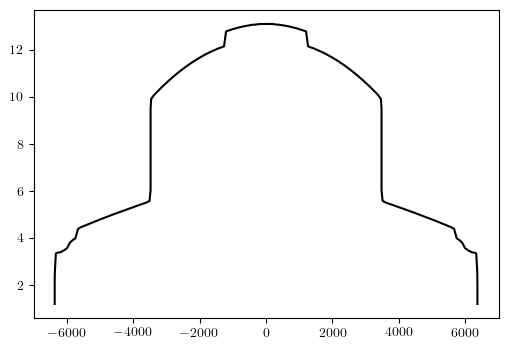

In [11]:
fig, ax = plt.subplots(figsize=(6,4))
plt.plot(r_data_earth_two_sides, rho_earth_two_sides, lw = 1.5, color = 'black', label = 'PREM')
plt.show()

In [12]:
f_density = interp1d(r_data_earth, rho_earth, fill_value = 'extrapolate')

In [13]:
nadir = np.pi/2
L = R_earth*np.sqrt(2*(1-np.cos(2*nadir)))
nu_path = np.linspace(0, L, 10000)

In [14]:
def nu_path(nadir):
    L = R_earth*np.sqrt(2*(1-np.cos(2*nadir)))
    path = np.linspace(0, L, 10000)
    rho_path = []
    for i in range(len(path)):
        r = np.sqrt(R_earth**2 + path[i]**2 - 2*R_earth*path[i]*np.cos(np.pi/2 - nadir))
        rho_path.append(f_density(r))
    rho_path = np.array(rho_path)
    return path, rho_path

100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


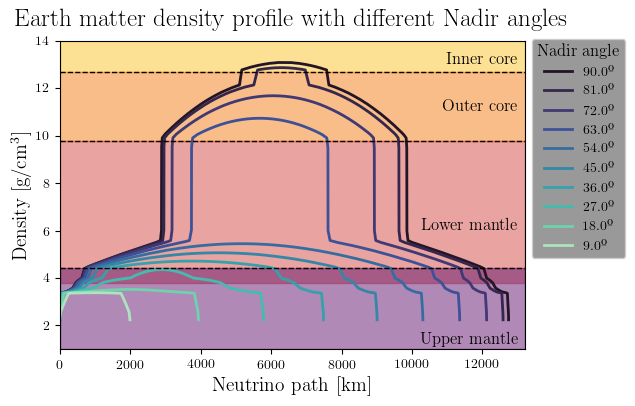

In [12]:
fig, ax = plt.subplots(figsize=(6,4))
for i in tqdm(range(10)):
    nadir = np.pi/2 - i*np.pi/20
    plt.plot(nu_path(nadir)[0], nu_path(nadir)[1], color = sns.color_palette('mako', 10)[i],
            label = f'{(nadir*180/np.pi):.1f}º', lw = 2)
# plt.plot(r_data_earth_two_sides, rho_earth_two_sides, lw = 1.5, color = 'black', label = 'PREM')
# plt.plot(x, f_density(x))
plt.xlabel('Neutrino path [km]', fontsize = 14)
plt.ylabel(r'Density [g/cm$^3$]', fontsize = 14)
plt.xlim(0, 13200)
plt.ylim(1, 14)
lgd = plt.legend(fontsize = 10, title = 'Nadir angle', bbox_to_anchor = (1,1.03),
                facecolor = 'grey')
lgd.get_title().set_fontsize(12)
plt.title('Earth matter density profile with different Nadir angles', fontsize = 18,
         pad = 10)
plt.axhline(12.7, lw = 1, ls = '--', color = 'black')
plt.text(13000, 13, 'Inner core', fontsize = 12, ha = 'right')
plt.fill_between([0, 13200], 12.7, 14, color = sns.color_palette('inferno', 6)[5], alpha = 0.5)
plt.axhline(9.8, lw = 1, ls = '--', color = 'black')
plt.text(13000, 11, 'Outer core', fontsize = 12, ha = 'right')
plt.fill_between([0, 13200], 9.8, 12.7, color = sns.color_palette('inferno', 6)[4], alpha = 0.5)
plt.axhline(4.4, lw = 1, ls = '--', color = 'black')
plt.text(13000, 6, 'Lower mantle', fontsize = 12, ha = 'right')
plt.fill_between([0, 13200], 3.8, 9.8, color = sns.color_palette('inferno', 6)[3], alpha = 0.5)
plt.text(13000, 1.2, 'Upper mantle', fontsize = 12, ha = 'right')
plt.fill_between([0, 13200], 1, 4.4, color = sns.color_palette('inferno', 6)[1], alpha = 0.5)
# plt.savefig('Plots/Earth_matter_density_profile_nadir_angle.png', dpi = 300, bbox_inches = 'tight')
# plt.savefig('Plots/Earth_matter_density_profile_nadir_angle.svg', dpi = 300, bbox_inches = 'tight')
plt.show()

In [13]:
dens_prof = []
distance_prof = []

for i in tqdm(range(100)):
    nadir = np.pi/2 - i*np.pi/200
    dens = nu_path(nadir)[1]
    dist = nu_path(nadir)[0]
    dens_prof.append(dens)
    distance_prof.append(dist)

100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


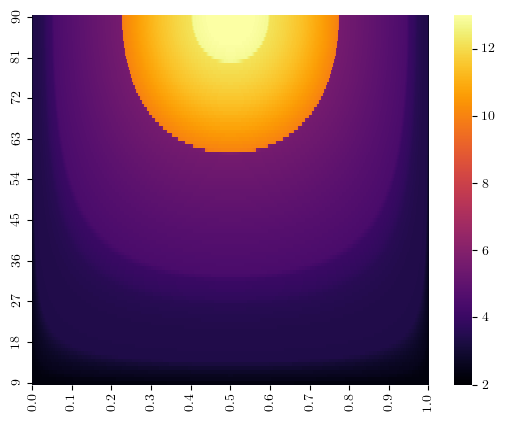

In [14]:
sns.heatmap(np.array(dens_prof), cmap = 'inferno', vmin = 2, vmax = 13)
plt.xticks([999*i + 0.5 for i in range(11)], labels = [f"{0.1*i:.1f}" for i in range(11)])
plt.yticks([11*i + 0.5 for i in range(10)], labels = [90 - 9*i for i in range(10)])
plt.show()

In [15]:
dens_prof = np.zeros((100, 10000))
inner_core = []

for i in tqdm(range(100)):
    nadir = np.pi/2 - i*np.pi/200
    L_max = 2*R_earth
    L = R_earth*np.sqrt(2*(1-np.cos(2*nadir)))
    path = np.arange(0, L, L_max/10000)
    for j in range(len(path)):
        r = np.sqrt(R_earth**2 + path[j]**2 - 2*R_earth*path[j]*np.cos(np.pi/2 - nadir))
        dens_prof[i,j] = f_density(r)
        # if np.isclose(f_density(r), 12.7, atol = 0.05):
        #     inner_core.append([i,j])

100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


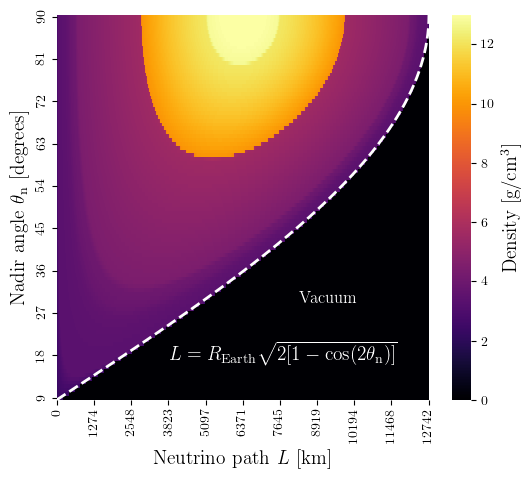

In [16]:
fig, ax = plt.subplots(figsize=(6,5))
htmp = sns.heatmap(dens_prof, cmap = 'inferno', ax = ax, vmin = 0, vmax = 13,
                   cbar_kws={'label': r'Density [g/cm$^3$]'})
# plt.scatter(np.array(inner_core)[:,1], np.array(inner_core)[:,0])
htmp.figure.axes[-1].yaxis.label.set_size(14)
plt.yticks([11*i + 0.5 for i in range(10)], labels = [90 - 9*i for i in range(10)])
plt.ylabel(r'Nadir angle $\theta_{\mathrm{n}}$ [degrees]', fontsize = 14)
plt.xticks([999*i for i in range(11)],
           labels = [int(np.round(0.1*i*L_max, 0)) for i in range(11)])
plt.xlabel('Neutrino path $L$ [km]', fontsize = 14)
plt.text(6500, 75, 'Vacuum', fontsize = 12, color = 'white')
y = np.linspace(0, 100, 1000)
plt.plot(5000*np.sqrt(2*(1-np.cos(2*y/63.6619))), -y+100,
        color = 'white', lw = 2, ls = '--')
plt.text(3000, 90, r'$L = R_{\mathrm{Earth}} \displaystyle \sqrt{2[1 - \cos(2\theta_{\mathrm{n}})]}$',
         fontsize = 14, color = 'white')
# plt.savefig('Plots/Neutrino_path_density_profile_nadir_angle.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [11]:
print(f'Average density of Earths core: {np.mean(data_ea[:np.where(data_ea[:,0] >= R_core)[0][0],1]*1e3/1e6):.2f} g/cm³')
print(f'Average density of Earths mantle: {np.mean(data_ea[np.where(data_ea[:,0] >= R_core)[0][0]:,1]*1e3/1e6):.2f} g/cm³')

print(f'\nAverage electron density of Earths core: {np.mean(data_ea_mol_e[:np.where(data_ea_mol_e[:,0] >= R_core)[0][0],1]):.2f} moles of e⁻/cm³')
print(f'Average electorn density of Earths mantle: {np.mean(data_ea_mol_e[np.where(data_ea_mol_e[:,0] >= R_core)[0][0]:,1]):.2f} moles of e⁻/cm³')

Average density of Earths core: 10.83 g/cm³
Average density of Earths mantle: 4.22 g/cm³

Average electron density of Earths core: 5.20 moles of e⁻/cm³
Average electorn density of Earths mantle: 2.20 moles of e⁻/cm³


In [ ]:
np.where(r_data_earth < 1220)[-1]

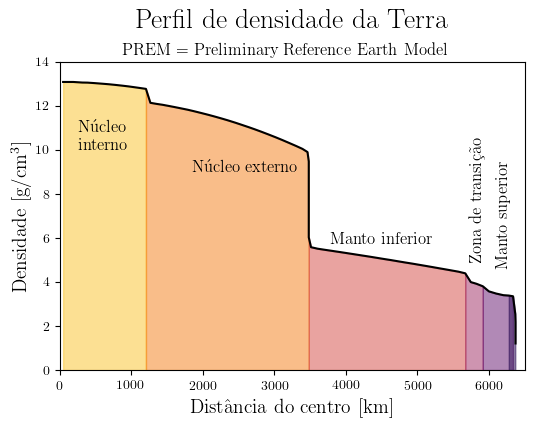

In [15]:
fig, ax = plt.subplots(figsize=(6,4))
plt.plot(r_data_earth, rho_earth, lw = 1.5, color = 'black', label = 'PREM')
plt.xlabel('Distância do centro [km]', fontsize = 14)
plt.ylabel(r'Densidade [g/cm$^3$]', fontsize = 14)
plt.xlim(0, 6500)
plt.text(600, 10, 'Núcleo \n interno', fontsize = 12, ha = 'center')
plt.text(2600, 9, 'Núcleo externo', fontsize = 12, ha = 'center')
plt.text(4500, 5.7, 'Manto inferior', fontsize = 12, ha = 'center')
plt.text(5750, 5, 'Zona de transição', fontsize = 12, rotation = 90)
plt.text(6100, 4.7, 'Manto superior', fontsize = 12, rotation = 90)
# plt.hlines(np.mean(data_ea[:np.where(data_ea[:,0] > R_core)[0][0],1]*1e3/1e6), 0, R_core,
#            ls = '--', color = sns.color_palette('inferno')[2])
# plt.hlines(np.mean(data_ea[np.where(data_ea[:,0] > R_core)[0][0]:,1]*1e3/1e6), R_core, R_earth,
#            ls = '--', color = sns.color_palette('inferno')[2], label = 'Two layer model')
# plt.vlines(R_core, np.mean(data_ea[np.where(data_ea[:,0] > R_core)[0][0]:,1]*1e3/1e6),
#            np.mean(data_ea[:np.where(data_ea[:,0] > R_core)[0][0],1]*1e3/1e6), ls = '--',
#            color = sns.color_palette('inferno')[2])
# plt.vlines(R_earth, 0, np.mean(data_ea[np.where(data_ea[:,0] > R_core)[0][0]:,1]*1e3/1e6), ls = '--',
#            color = sns.color_palette('inferno')[2])
plt.ylim(0, 14)
# plt.legend(loc = 'upper right', fontsize = 12)
plt.title('Perfil de densidade da Terra', fontsize = 20, pad = 24)
fig.text(0.5, 0.9, 'PREM = Preliminary Reference Earth Model', fontsize = 12,
       ha = 'center')
plt.fill_between(r_data_earth[:np.where(r_data_earth > 1220)[0][0]],
                 0, rho_earth[:np.where(r_data_earth > 1220)[0][0]],
                 color = sns.color_palette('inferno', 6)[5], alpha = 0.5)
plt.fill_between(r_data_earth[np.where(r_data_earth < 1220)[0][-1]:np.where(r_data_earth > R_core)[0][0]],
                 0, rho_earth[np.where(r_data_earth < 1220)[0][-1]:np.where(r_data_earth > R_core)[0][0]],
                 color = sns.color_palette('inferno', 6)[4], alpha = 0.5)
plt.fill_between(r_data_earth[np.where(r_data_earth < R_core)[0][-1]:np.where(r_data_earth > R_earth-660)[0][0]],
                 0, rho_earth[np.where(r_data_earth < R_core)[0][-1]:np.where(r_data_earth > R_earth-660)[0][0]],
                 color = sns.color_palette('inferno', 6)[3], alpha = 0.5)
plt.fill_between(r_data_earth[np.where(r_data_earth < R_earth-660)[0][-1]:np.where(r_data_earth > R_earth-410)[0][0]],
                 0, rho_earth[np.where(r_data_earth < R_earth-660)[0][-1]:np.where(r_data_earth > R_earth-410)[0][0]],
                 color = sns.color_palette('inferno', 6)[2], alpha = 0.5)
plt.fill_between(r_data_earth[np.where(r_data_earth < R_earth-410)[0][-1]:np.where(r_data_earth > R_earth-30)[0][0]],
                 0, rho_earth[np.where(r_data_earth < R_earth-410)[0][-1]:np.where(r_data_earth > R_earth-30)[0][0]],
                 color = sns.color_palette('inferno', 6)[1], alpha = 0.5)
plt.fill_between(r_data_earth[np.where(r_data_earth < R_earth-35)[0][-1]:np.where(r_data_earth > R_earth)[0][0]],
                 0, rho_earth[np.where(r_data_earth < R_earth-35)[0][-1]:np.where(r_data_earth > R_earth)[0][0]],
                 color = sns.color_palette('inferno', 6)[0], alpha = 0.5)

# ax2 = ax.twinx()
# ax2.plot(r_data_earth, rho_earth, lw = 1.5, color = 'black')
# ax2.set_yticks([0,2,4,6,8,10,12,14])
# ax2.set_yticklabels([0,1,2,3,4,5,6,7])
# ax2.set_ylabel(r'Electron density [moles of $e^-$/cm$^3$]', fontsize = 14)
# ax2.set_xlim(0, 6500)

plt.savefig('/home/pedroc/Documentos/pedro/Graficos_geral/Earth_density_profile_pt-br.png', dpi = 300, bbox_inches = 'tight')
# plt.savefig('Plots/Earth_density_profile.svg', dpi = 300, bbox_inches = 'tight')
plt.show()

In [15]:
super_k_lat = 36.42*np.pi/180
super_k_lon = 137.31*np.pi/180
z = R_earth*np.cos(np.pi/2 - super_k_lat)
x = R_earth*np.sin(np.pi/2 - super_k_lat)*np.cos(super_k_lon)
y = R_earth*np.sin(np.pi/2 - super_k_lat)*np.sin(super_k_lon)

In [16]:
RA = 80.745
Dec = -69.75
RA_sn1987 = 80.745
Dec_sn1987 = -69.75

In [38]:
detec_time = datetime.datetime(2023,9,27,7,35,0)
detec_sn1987 = datetime.datetime(1987,2,23,7,35,0)

In [39]:
observing_location = EarthLocation(lat=0*u.deg, lon=0*u.deg)
observing_time = Time(detec_time, scale='utc', location=observing_location)
observing_time_sn1987 = Time(detec_sn1987, scale='utc', location=observing_location)
GMST = observing_time.sidereal_time('mean')
GMST_sn1987 = observing_time_sn1987.sidereal_time('mean')
GMST_deg = GMST.hour*15
GMST_deg_sn1987 = GMST_sn1987.hour*15

In [40]:
# nu_lat = -36.42*np.pi/180
# nu_lon = 137.31*np.pi/180 - np.pi
nu_lat = Dec
nu_lon = (RA - GMST_deg)*np.pi/180

sn1987_lat = Dec_sn1987
sn1987_lon = (RA_sn1987 - GMST_deg_sn1987)*np.pi/180

z2 = R_earth*np.cos(np.pi/2 - nu_lat)
x2 = R_earth*np.sin(np.pi/2 - nu_lat)*np.cos(nu_lon)
y2 = R_earth*np.sin(np.pi/2 - nu_lat)*np.sin(nu_lon)

z3 = R_earth*np.cos(np.pi/2 - sn1987_lat)
x3 = R_earth*np.sin(np.pi/2 - sn1987_lat)*np.cos(sn1987_lon)
y3 = R_earth*np.sin(np.pi/2 - sn1987_lat)*np.sin(sn1987_lon)

In [41]:
A = [x, y, z]
B = [x2, y2, z2]
C = [x3, y3, z3]

In [42]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [43]:
alpha = angle_between(A, np.subtract(A, B))#*180/np.pi
alpha2 = angle_between(A, np.subtract(A, C))#*180/np.pi

In [44]:
nadir = np.pi/2 - alpha
nadir2 = np.pi/2 - alpha2

In [45]:
print(nadir*180/np.pi)
print(nadir2*180/np.pi)

88.45336472021593
40.24845100761514


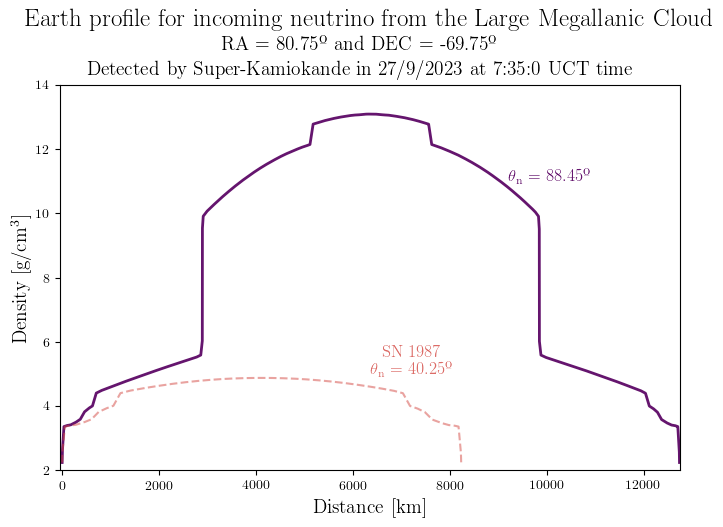

In [54]:
fig, ax = plt.subplots(figsize = (8,5))
plt.plot(nu_path(nadir)[0], nu_path(nadir)[1], color = sns.color_palette('inferno')[1],
        lw = 2)
plt.plot(nu_path(nadir2)[0], nu_path(nadir2)[1], color = sns.color_palette('inferno')[3],
        lw = 1.5, ls = '--', alpha = 0.5)
plt.xlabel('Distance [km]', fontsize = 14)
plt.ylabel('Density [g/cm$^3$]', fontsize = 14)
plt.xlim(-50, 2*R_earth)
plt.ylim(2, 14)
plt.title(f'Earth profile for incoming neutrino from the Large Megallanic Cloud',
         fontsize = 18, pad = 42)
fig.text(0.5, 0.95, f'RA = {RA:.2f}º and DEC = {Dec:.2f}º', fontsize = 14, ha = 'center')
fig.text(0.5, 0.9, f'Detected by Super-Kamiokande in {detec_time.day}/{detec_time.month}/{detec_time.year} at {detec_time.hour}:{detec_time.minute}:{detec_time.second} UCT time', fontsize = 14, ha = 'center')
plt.text(7200, 5.5, 'SN 1987', fontsize = 12, color = sns.color_palette('inferno')[3], alpha = 0.8,
        ha = 'center')
plt.text(7200, 5, r'$\theta_{\mathrm{n}}$ = ' f'{nadir2*180/np.pi:.2f}º',
         fontsize = 12, color = sns.color_palette('inferno')[3], alpha = 0.8, ha = 'center')

plt.text(9200, 11, r'$\theta_{\mathrm{n}}$ = ' f'{nadir*180/np.pi:.2f}º',
         fontsize = 12, color = sns.color_palette('inferno')[1])
fig.patch.set_alpha(0)
for ax in fig.axes:
    ax.patch.set_alpha(0.2)

plt.savefig('Plots/Earth_profile_incoming_neutrino_LMC_27-09-2023.png', dpi = 300, bbox_inches = 'tight')
plt.savefig('Plots/Earth_profile_incoming_neutrino_LMC_27-09-2023.svg', dpi = 300, bbox_inches = 'tight')
plt.show()

---

In [5]:
def theta_matter(E, N_e):
    """
    Effective neutrino mixing angle in matter
    see equation (2) above
    """
    delta_mbar = 7.54 # eV^2
    theta_12 = 33.447*np.pi/180
    G_F = 1.16e-23
    g_to_eV = c**2 / 1000 * 6.242e18
    cm3_to_eV3 = (0.197e9*1e-15*100)**3
    A = 2*np.sqrt(2)*G_F*E*N_e*cm3_to_eV3*Na
    sin_2_2thetam = np.sin(2*theta_12)**2 / (np.sin(2*theta_12)**2 + (np.cos(2*theta_12) - A/delta_mbar)**2)
    thetam = np.arcsin(np.sqrt(sin_2_2thetam))/2
    return thetam

In [6]:
def theta_matter_diff(E, N_ec):
    """
    Effective neutrino mixing angle in matter
    see equation (2) above
    """
    theta = theta_matter(E, -1.5e11) - theta_matter(E, N_ec)
    return theta

def theta_matter_diff_2(E, N_em):
    """
    Effective neutrino mixing angle in matter
    see equation (2) above
    """
    theta = theta_12 - theta_matter(E, N_em)
    return theta

In [7]:
data = np.loadtxt('/home/pedroc/Documentos/pedro/Mestradives/Simulations/Supernova-neutrinos/Data/test_paper_la_do_efeito_de_materia_terra.txt',
          delimiter = '; ')
data2 = np.loadtxt('/home/pedroc/Documentos/pedro/Mestradives/Simulations/Supernova-neutrinos/Data/test_paper_la_do_efeito_de_materia_terra_2.txt',
          delimiter = '; ')

In [8]:
c, cov = curve_fit(theta_matter_diff, data[:,0], data[:,1], p0 = (-1e10,))
c2, cov2 = curve_fit(theta_matter_diff_2, data2[:,0], data2[:,1], p0 = (-1e10,))

In [9]:
c[0]

-391697925762.5642

In [10]:
c2[0]

-150060250216.29025

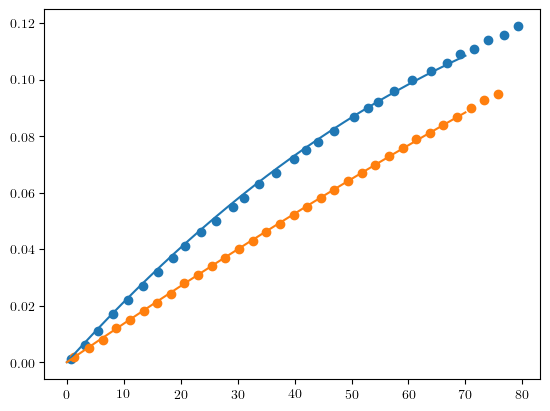

In [11]:
plt.scatter(data[:,0], data[:,1])
plt.scatter(data2[:,0], data2[:,1])
plt.plot(E, theta_matter_diff(E, *c))
plt.plot(E, theta_matter_diff_2(E, *c2))
plt.show()

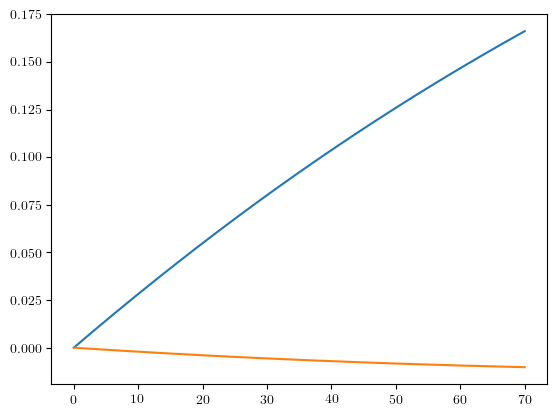

In [12]:
theta_m = theta_matter(-2.2*Avog/4.22/1e12, E)
theta_c = theta_matter(-5.2*Avog/10.8/1e12, E)

plt.plot(E, theta_12 - theta_m)
plt.plot(E, theta_m - theta_c)
plt.show()

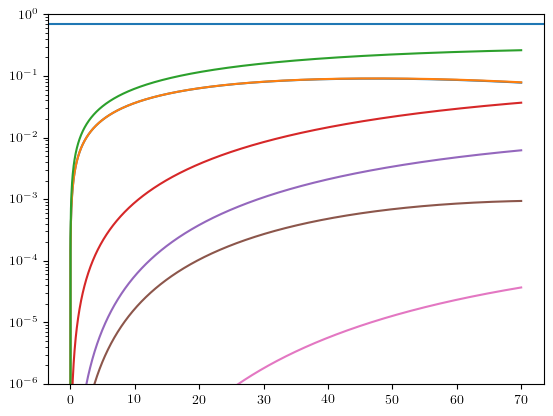

In [13]:
theta_m = theta_matter(E, c[0])
theta_c = theta_matter(E, c2[0])

As = [-0.5*np.sin(2*theta_12 - 4*theta_m)*np.sin(4*theta_c - 4*theta_m),
      (np.cos(theta_c - theta_m)**2)*np.sin(2*theta_12 - 4*theta_m)*np.sin(2*theta_c - 2*theta_m),
      np.sin(2*theta_12 - 2*theta_m)*(np.cos(theta_c - theta_m)**4)*np.sin(2*theta_m),
      -(np.sin(2*theta_c - 2*theta_m)**2)*(np.cos(2*theta_12 - 4*theta_m) - 0.5*np.sin(2*theta_12 - 2*theta_m)*np.sin(2*theta_m)),
      0.5*np.sin(2*theta_12 - 2*theta_m)*np.sin(2*theta_m)*np.sin(2*theta_c - 2*theta_m)**2,
      -2*np.sin(2*theta_12 - 4*theta_m)*np.cos(theta_c - theta_m)*np.sin(theta_c - theta_m)**3,
      np.sin(2*theta_12 - 2*theta_m)*(np.sin(theta_c - theta_m)**4)*np.sin(2*theta_m)]

for i in range(len(As)):
    plt.plot(E, np.abs(As[i]))

plt.yscale('log')
plt.ylim(1e-6, 1)
plt.axhline(np.cos(theta_12)**2)
plt.show()

In [14]:
N_e_m = c[0]
N_e_c = c2[0]

In [15]:
def prob(E, phi, info = True):
    """
    Antineutrino electron survival probability as function
    of energy and nadir angle
    """
    theta_m = theta_matter(N_e_m, E)
    theta_c = theta_matter(N_e_c, E)
    y = 12.5/E
    
    As = [-0.5*np.sin(2*theta_12 - 4*theta_m)*np.sin(4*theta_c - 4*theta_m),
          (np.cos(theta_c - theta_m)**2)*np.sin(2*theta_12 - 4*theta_m)*np.sin(2*theta_c - 2*theta_m),
          np.sin(2*theta_12 - 2*theta_m)*(np.cos(theta_c - theta_m)**4)*np.sin(2*theta_m),
          -(np.sin(2*theta_c - 2*theta_m)**2)*(np.cos(2*theta_12 - 4*theta_m) - 0.5*np.sin(2*theta_12 - 2*theta_m)*np.sin(2*theta_m)),
          0.5*np.sin(2*theta_12 - 2*theta_m)*np.sin(2*theta_m)*np.sin(2*theta_c - 2*theta_m)**2,
          -2*np.sin(2*theta_12 - 4*theta_m)*np.cos(theta_c - theta_m)*np.sin(theta_c - theta_m)**3,
          np.sin(2*theta_12 - 2*theta_m)*np.sin(2*theta_m)*np.sin(theta_c - theta_m)**4]
    
    L_tot = R_earth*np.sqrt(2*(1 - np.cos(2*phi))) # km
    if phi > 0.9947:
        L_m = (R_earth*np.sin(phi) - np.sqrt(R_core**2 - (np.cos(phi)**2)*(R_earth**2)))
    else:
        L_m = L_tot
    L_c = L_tot - L_m
    if info:
        print(f'Total distance travelled: {L_tot:.2f}'
             '\n'
             f'Mantle distance: {L_m:.2f}'
             '\n'
             f'Core distance: {L_c:.2f}'
             '\n'
             f'Core + Mantle distance: {(L_m + L_c):.2f}')
    sigma_m = 2*delta_mbar*np.sin(2*theta_12)*L_m*y/(np.sin(2*theta_m)*1e3*1e-5)
    sigma_c = 2*delta_mbar*np.sin(2*theta_12)*L_c*y/(np.sin(2*theta_c)*1e3*1e-5)
    sigmas = [sigma_m/2, sigma_m/2 + sigma_c, sigma_m + sigma_c, sigma_c, sigma_m,
              sigma_m/2 - sigma_c, sigma_m - sigma_c]
    P = np.cos(theta_12)**2
    for i in range(7):
        P += As[i]*np.sin(sigmas[i]/2)**2
    return P

In [16]:
prob(10, 10*np.pi/180, info = True)

Total distance travelled: 2212.63
Mantle distance: 2212.63
Core distance: 0.00
Core + Mantle distance: 2212.63


0.7247668757346992

In [35]:
E = np.linspace(0, 80, 320)
phi = np.linspace(0, np.pi/2, 360)

In [36]:
probs = np.zeros((len(E), len(phi)))

for i in tqdm(range(len(E))):
    for j in range(len(phi)):
        probs[i,j] = prob(E[i], phi[j], info = False)

100%|██████████| 320/320 [00:09<00:00, 32.19it/s]


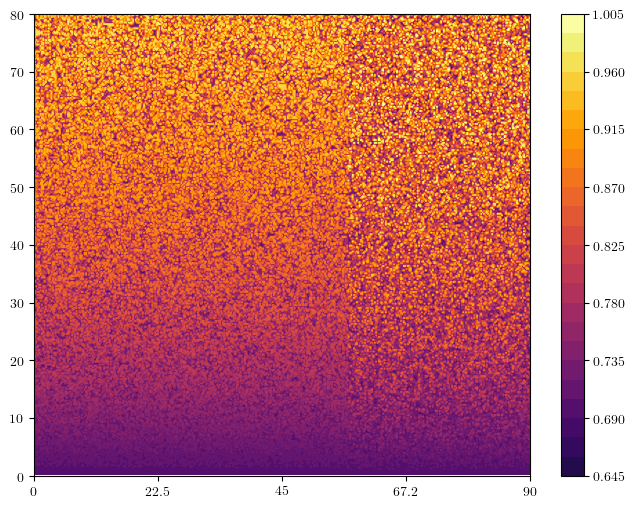

In [38]:
fig, ax = plt.subplots(figsize = (8,6))
plt.contourf(phi, E, probs, levels = 30, vmin = 0.6, vmax = 1, cmap = 'inferno')
plt.colorbar()
plt.xticks([0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2],
           labels = [0, 22.5, 45, 67.2, 90])
# plt.ylim(0, 2)
plt.show()

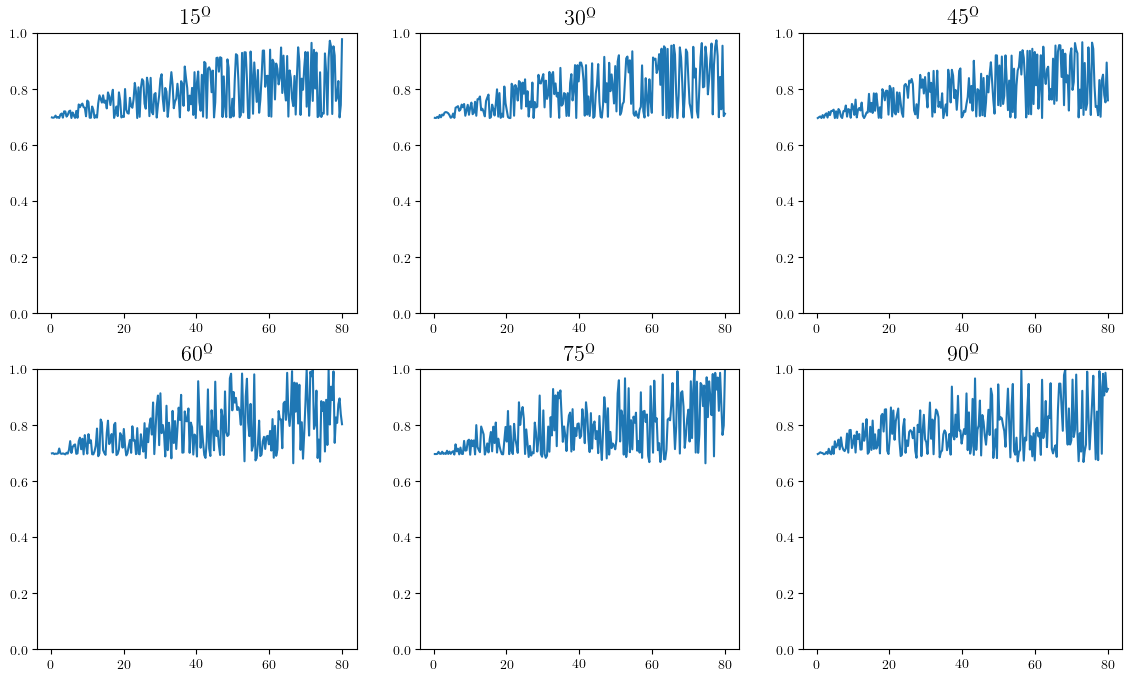

In [26]:
title_size = 16
fig, axs = plt.subplots(2, 3, figsize = (14,8))
ax = axs.flatten()
ax[0].plot(E, prob(E, 15*np.pi/180, info = False))
ax[0].set_ylim(0, 1)
ax[0].set_title('15º', fontsize = title_size)
ax[1].plot(E, prob(E, 30*np.pi/180, info = False))
ax[1].set_ylim(0, 1)
ax[1].set_title('30º', fontsize = title_size)
ax[2].plot(E, prob(E, 45*np.pi/180, info = False))
ax[2].set_ylim(0, 1)
ax[2].set_title('45º', fontsize = title_size)
ax[3].plot(E, prob(E, 60*np.pi/180, info = False))
ax[3].set_ylim(0, 1)
ax[3].set_title('60º', fontsize = title_size)
ax[4].plot(E, prob(E, 75*np.pi/180, info = False))
ax[4].set_ylim(0, 1)
ax[4].set_title('75º', fontsize = title_size)
ax[5].plot(E, prob(E, 90*np.pi/180, info = False))
ax[5].set_ylim(0, 1)
ax[5].set_title('90º', fontsize = title_size)

plt.show()

In [27]:
def produced_spectrum(x, alpha = 2.76, E_mean = 11.06, E_tot = 1e53):
    L = E_tot*6.2415e5
    A = L*((1+alpha)**(1+alpha))/((gamma(1+alpha))*E_mean**(2+alpha))
    f_nu = A*(x**alpha)*np.exp(-(alpha + 1)*x/E_mean)
    return f_nu

In [28]:
def emitted_spectrum_nubar_e(x, phi, alpha_e = 2.90, E_mean_e = 10.14, E_tot_e = 5e52,
                    alpha_ebar = 2.78, E_mean_ebar = 12.69, E_tot_ebar = 5e52,
                    alpha_x = 2.39, E_mean_x = 12.89, E_tot_x = 5e52, osc = True):
    F_e = produced_spectrum(x, alpha_e, E_mean_e, E_tot_e)
    F_ebar = produced_spectrum(x, alpha_ebar, E_mean_ebar, E_tot_ebar)
    F_x = produced_spectrum(x, alpha_x, E_mean_x, E_tot_x)
    y = 12.5/x
    L_tot = R_earth*np.sqrt(2*(1 - np.cos(2*phi))) # km
    if phi > 0.9947:
        L_m = (R_earth*np.sin(phi) - np.sqrt(R_core**2 - (np.cos(phi)**2)*(R_earth**2)))
    else:
        L_m = L_tot
    L_c = L_tot - L_m
    theta_m = theta_matter(N_e_m, x)
    theta_c = theta_matter(N_e_c, x)
    
    As = [-0.5*np.sin(2*theta_12 - 4*theta_m)*np.sin(4*theta_c - 4*theta_m),
          (np.cos(theta_c - theta_m)**2)*np.sin(2*theta_12 - 4*theta_m)*np.sin(2*theta_c - 2*theta_m),
          np.sin(2*theta_12 - 2*theta_m)*(np.cos(theta_c - theta_m)**4)*np.sin(2*theta_m),
          -(np.sin(2*theta_c - 2*theta_m)**2)*(np.cos(2*theta_12 - 4*theta_m) - 0.5*np.sin(2*theta_12 - 2*theta_m)*np.sin(2*theta_m)),
          0.5*np.sin(2*theta_12 - 2*theta_m)*np.sin(2*theta_m)*np.sin(2*theta_c - 2*theta_m)**2,
          -2*np.sin(2*theta_12 - 4*theta_m)*np.cos(theta_c - theta_m)*np.sin(theta_c - theta_m)**3,
          np.sin(2*theta_12 - 2*theta_m)*np.sin(2*theta_m)*np.sin(theta_c - theta_m)**4]
    
    sigma_m = 2*delta_mbar*np.sin(2*theta_12)*L_m*y/(np.sin(2*theta_m)*1e3*1e-5)
    sigma_c = 2*delta_mbar*np.sin(2*theta_12)*L_c*y/(np.sin(2*theta_c)*1e3*1e-5)
    sigmas = [sigma_m/2, sigma_m/2 + sigma_c, sigma_m + sigma_c, sigma_c, sigma_m,
              sigma_m/2 - sigma_c, sigma_m - sigma_c]
    
    P = 0
    for i in range(7):
        P += As[i]*np.sin(sigmas[i]/2)**2
    if osc:
        return F_x*np.sin(theta_12)**2 + F_ebar*np.cos(theta_12)**2 + (F_ebar - F_x)*P
    else:
        return F_ebar

In [29]:
def fitting_spectrum(x, alpha = 2.76, E_mean = 11.06, E_tot = 5e52):
    F = produced_spectrum(x, alpha, E_mean, E_tot)
    return F

def fitting_oscillation(x, A, phi, alpha, E_mean, E_tot):
    F = produced_spectrum(x, alpha, E_mean, E_tot)
    y = 12.5/x
    L_tot = R_earth*np.sqrt(2*(1 - np.cos(2*phi))) # km
    if phi > 0.9947:
        L_m = (R_earth*np.sin(phi) - np.sqrt(R_core**2 - (np.cos(phi)**2)*(R_earth**2)))
    else:
        L_m = L_tot
    L_c = L_tot - L_m
    theta_m = theta_matter(N_e_m, x)
    theta_c = theta_matter(N_e_c, x)
    
    As = [-0.5*np.sin(2*theta_12 - 4*theta_m)*np.sin(4*theta_c - 4*theta_m),
          (np.cos(theta_c - theta_m)**2)*np.sin(2*theta_12 - 4*theta_m)*np.sin(2*theta_c - 2*theta_m),
          np.sin(2*theta_12 - 2*theta_m)*(np.cos(theta_c - theta_m)**4)*np.sin(2*theta_m),
          -(np.sin(2*theta_c - 2*theta_m)**2)*(np.cos(2*theta_12 - 4*theta_m) - 0.5*np.sin(2*theta_12 - 2*theta_m)*np.sin(2*theta_m)),
          0.5*np.sin(2*theta_12 - 2*theta_m)*np.sin(2*theta_m)*np.sin(2*theta_c - 2*theta_m)**2,
          -2*np.sin(2*theta_12 - 4*theta_m)*np.cos(theta_c - theta_m)*np.sin(theta_c - theta_m)**3,
          np.sin(2*theta_12 - 2*theta_m)*np.sin(2*theta_m)*np.sin(theta_c - theta_m)**4]
    
    sigma_m = 2*delta_mbar*np.sin(2*theta_12)*L_m*y/(np.sin(2*theta_m)*1e3*1e-5)
    sigma_c = 2*delta_mbar*np.sin(2*theta_12)*L_c*y/(np.sin(2*theta_c)*1e3*1e-5)
    sigmas = [sigma_m/2, sigma_m/2 + sigma_c, sigma_m + sigma_c, sigma_c, sigma_m,
              sigma_m/2 - sigma_c, sigma_m - sigma_c]
    
    P = 0
    for i in range(7):
        P += As[i]*np.sin(sigmas[i]/2)**2
    return F + A*P

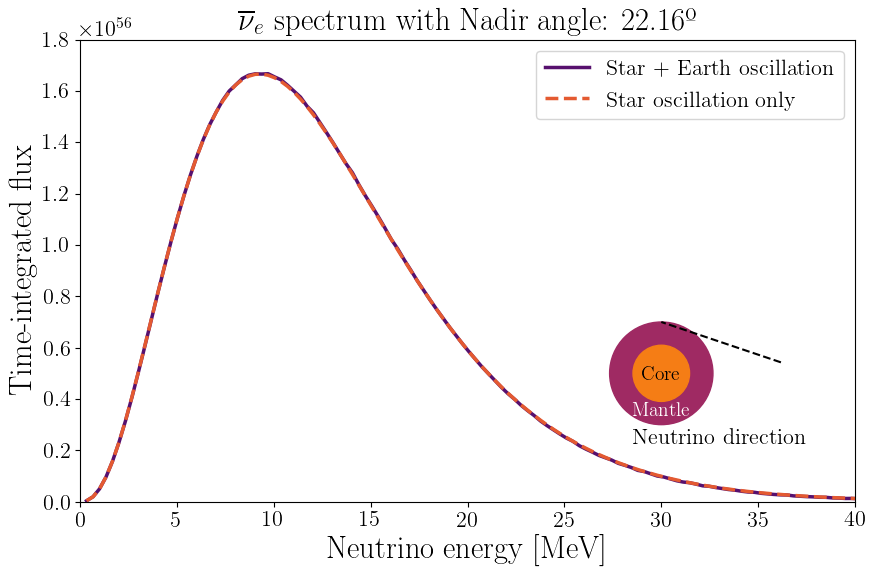

In [30]:
phi = np.linspace(0, np.pi/2, 200)

ration_mc = R_core/R_earth

# for i in tqdm(range(len(phi))):
i = 49
fig, ax = plt.subplots(figsize=(10,6))
# plt.plot(E, emitted_spectrum_nubar_e(E, 0, osc = False), lw = 2.5, color = 'teal', ls = '--',
#         label = 'No oscillation')
plt.plot(E, emitted_spectrum_nubar_e(E, phi[i]), lw = 2.5, color = sns.color_palette('inferno', 7)[1],
        label = 'Star + Earth oscillation')
plt.plot(E, emitted_spectrum_nubar_e(E, 0, osc = True), lw = 2.5, color = sns.color_palette('inferno', 7)[4],
         ls = '--', label = 'Star oscillation only')
center_x = 30
center_y = 0.5e56
y_lim_up = 1.8e56
x_lim_up = 40
circ1 = mpl.patches.Ellipse((center_x, center_y), 8*(x_lim_up/60), y_lim_up*0.1333*10/6, fill = True, color = sns.color_palette('inferno')[2])
circ2 = mpl.patches.Ellipse((center_x, center_y), 8*x_lim_up*ration_mc/60, y_lim_up*ration_mc*0.1333*10/6, fill = True, color = sns.color_palette('inferno')[4])
ax.add_patch(circ1)
ax.add_patch(circ2)
plt.plot([center_x+10*np.cos(phi[i])*(x_lim_up/60),center_x], [center_y+y_lim_up*0.1333*10/12-1.6667*y_lim_up*0.1667*10*np.sin(phi[i])/12, center_y+y_lim_up*0.1333*10/12],
         lw = 1.5, ls = '--', color = 'black')
plt.xlim(0, x_lim_up)
plt.ylim(0, y_lim_up)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.yaxis.offsetText.set_fontsize(16)
plt.xlabel('Neutrino energy [MeV]', fontsize = 22)
plt.ylabel('Time-integrated flux', fontsize = 22)
plt.title(r'$\overline \nu_e$ spectrum with Nadir angle: {:.2f}º'.format(phi[i]*180/np.pi), fontsize = 22)
plt.text(center_x, 0.33e56, 'Mantle', fontsize = 14, ha = 'center', color = 'white')
plt.text(center_x, 0.47e56, 'Core', fontsize = 14, ha = 'center')
plt.text(1.1*center_x, 0.22e56, 'Neutrino direction', fontsize = 16, ha = 'center')
plt.legend(loc = 'upper right', fontsize = 16)
fig.patch.set_alpha(0.3)
for ax in fig.axes:
    ax.patch.set_alpha(0.5)
# plt.savefig(f'Plots/Earth_matter_effect_{phi[i]:.2f}.svg',
#             dpi = 300, bbox_inches = 'tight')
# plt.savefig(f'/home/pedroc/Documentos/pedro/Mestradives/Simulations/Gifs/Earth_matter_effect_{i}.png',
#             dpi = 300, bbox_inches = 'tight')
# plt.close()
plt.show()

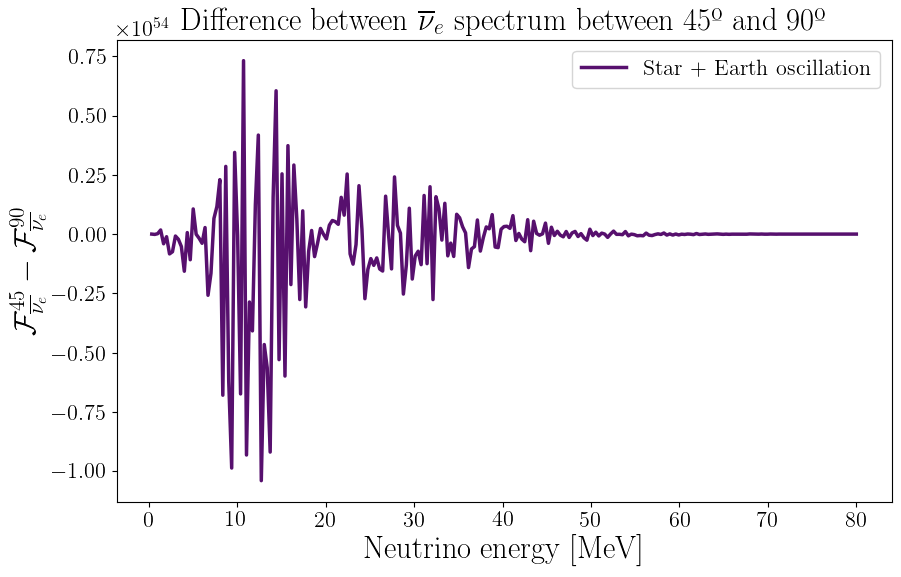

In [31]:
phi = np.linspace(0, np.pi/2, 200)

ration_mc = R_core/R_earth

# for i in tqdm(range(len(phi))):
fig, ax = plt.subplots(figsize=(10,6))
# plt.plot(E, emitted_spectrum_nubar_e(E, 0, osc = False), lw = 2.5, color = 'teal', ls = '--',
#         label = 'No oscillation')
plt.plot(E, emitted_spectrum_nubar_e(E, np.pi/4)-emitted_spectrum_nubar_e(E, np.pi/2), lw = 2.5, color = sns.color_palette('inferno', 7)[1],
        label = 'Star + Earth oscillation')
# center_x = 30
# center_y = 0.5e56
# y_lim_up = 1.8e56
# x_lim_up = 40
# circ1 = mpl.patches.Ellipse((center_x, center_y), 8*(x_lim_up/60), y_lim_up*0.1333*10/6, fill = True, color = sns.color_palette('inferno')[2])
# circ2 = mpl.patches.Ellipse((center_x, center_y), 8*x_lim_up*ration_mc/60, y_lim_up*ration_mc*0.1333*10/6, fill = True, color = sns.color_palette('inferno')[4])
# ax.add_patch(circ1)
# ax.add_patch(circ2)
# plt.plot([center_x+10*np.cos(phi[i])*(x_lim_up/60),center_x], [center_y+y_lim_up*0.1333*10/12-1.6667*y_lim_up*0.1667*10*np.sin(phi[i])/12, center_y+y_lim_up*0.1333*10/12],
#          lw = 1.5, ls = '--', color = 'black')
# plt.xlim(0, x_lim_up)
# plt.ylim(0, y_lim_up)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.yaxis.offsetText.set_fontsize(16)
plt.xlabel('Neutrino energy [MeV]', fontsize = 22)
plt.ylabel(r'$\mathcal{F}_{\overline{\nu_e}}^{45} - \mathcal{F}_{\overline{\nu_e}}^{90}$', fontsize = 22)
plt.title(r'Difference between $\overline \nu_e$ spectrum between 45º and 90º', fontsize = 22)
# plt.text(center_x, 0.33e56, 'Mantle', fontsize = 14, ha = 'center', color = 'white')
# plt.text(center_x, 0.47e56, 'Core', fontsize = 14, ha = 'center')
# plt.text(1.1*center_x, 0.22e56, 'Neutrino direction', fontsize = 16, ha = 'center')
plt.legend(loc = 'upper right', fontsize = 16)
fig.patch.set_alpha(0.3)
for ax in fig.axes:
    ax.patch.set_alpha(0.5)
# plt.savefig(f'Plots/Earth_matter_effect_{phi[i]:.2f}.svg',
#             dpi = 300, bbox_inches = 'tight')
# plt.savefig(f'/home/pedroc/Documentos/pedro/Mestradives/Simulations/Gifs/Earth_matter_effect_{i}.png',
#             dpi = 300, bbox_inches = 'tight')
# plt.close()
plt.show()

In [ ]:
energy = np.linspace(0.001, 100, 2000000)
plt.plot(energy, dtc.detection_spectra(energy, 1e53, flavor = 'nubar_e', detector = 'Hyper-k',
                    hierarchy = 'normal', distance = 10, phi = np.pi/4))
plt.xlim(0, 60)

In [369]:
dtc.detection_spectra(energy, 1e53, flavor = 'nubar_e', detector = 'Hyper-k',
                    hierarchy = 'normal', distance = 10, phi = np.pi/4)/simps(dtc.detection_spectra(energy, 1e53, flavor = 'nubar_e', detector = 'Hyper-k',
                    hierarchy = 'normal', distance = 10, phi = np.pi/4))

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       1.66699473e-11, 1.66697898e-11, 1.66696324e-11])

In [19]:
bin_width = 0.1 # MeV
n_bins = 150

energy = np.linspace(0.001, 100, 2000000)
phi = np.linspace(0, np.pi/2, 200)
weights = emitted_spectrum_nubar_e(energy, phi[150])
samples = choices(energy, weights, k = 10000000)

In [22]:
samples_sorted = np.sort(samples)
samples_low = samples_sorted[:np.where(samples_sorted < 15)[0][-1]]
y, bins = np.histogram(samples_low, bins = [bin_width*i for i in range(n_bins+1)], density = True)

In [23]:
x = (bins[1:] + bins[:-1])/2

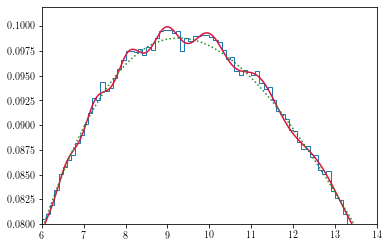

In [25]:
plt.hist(samples_low, bins = [bin_width*i for i in range(n_bins+1)], histtype = 'step', density = True)
plt.plot(energy, emitted_spectrum_nubar_e(energy, phi[150])/simps(emitted_spectrum_nubar_e(energy[:np.where(energy < 15)[0][-1]], phi[150]), energy[:np.where(energy < 15)[0][-1]]),
         lw = 1.5, color = 'crimson')
plt.plot(energy, emitted_spectrum_nubar_e(energy, 0, osc = True)/simps(emitted_spectrum_nubar_e(energy[:np.where(energy < 15)[0][-1]], 0), energy[:np.where(energy < 15)[0][-1]]),
         lw = 1.5, color = 'forestgreen', ls = 'dotted')
plt.xlim(6, 14)
plt.ylim(0.08, 0.102)
plt.show()

In [26]:
len(samples_low)

6905045

In [28]:
print(f"Erro mediano com oscilação: {np.median(np.abs(y - emitted_spectrum_nubar_e(x, phi[150])/simps(emitted_spectrum_nubar_e(x, phi[150]), x))):.6f}"
     '\n'
     f"Erro mediano sem oscilação: {np.median(np.abs(y - emitted_spectrum_nubar_e(x, 0)/simps(emitted_spectrum_nubar_e(x, 0), x))):.6f}")

Erro mediano com oscilação: 0.000299
Erro mediano sem oscilação: 0.000424


In [29]:
st.ks_2samp(y - emitted_spectrum_nubar_e(x, phi[150])/simps(emitted_spectrum_nubar_e(x, phi[150]), x),
            y - emitted_spectrum_nubar_e(x, 0)/simps(emitted_spectrum_nubar_e(x, 0), x))

KstestResult(statistic=0.13333333333333333, pvalue=0.13906219315479607)

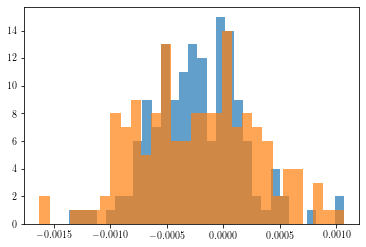

In [30]:
plt.hist(y - emitted_spectrum_nubar_e(x, phi[150])/simps(emitted_spectrum_nubar_e(x, phi[150]), x),
        bins = 30, alpha = 0.7)
plt.hist(y - emitted_spectrum_nubar_e(x, 0)/simps(emitted_spectrum_nubar_e(x, 0), x),
        bins = 30, alpha = 0.7)
plt.show()

In [187]:
bin_widths = [1,0.5,0.25,0.1,0.05] # MeV
n_binss = [60,200,300,600,1200]
p_values = []

for i in range(len(bin_widths)):
    ps = []
    print(f'Bin width: {bin_widths[i]} MeV')
    for j in tqdm(range(40)):
        samples = choices(energy, weights, k = 10000000)
        y, bins = np.histogram(samples, bins = [bin_widths[i]*k for k in range(n_binss[i]+1)], density = True)
        x = (bins[1:] + bins[:-1])/2
        ks, p = st.ks_2samp(np.abs(y - emitted_spectrum_nubar_e(x, phi[150])/simps(emitted_spectrum_nubar_e(x, phi[150]), x)),
                    np.abs(y - emitted_spectrum_nubar_e(x, 0)/simps(emitted_spectrum_nubar_e(x, 0), x)))
        ps.append(p)
    p_values.append(ps)

Bin width: 1 MeV


100%|██████████| 40/40 [29:07<00:00, 43.69s/it]


Bin width: 0.5 MeV


100%|██████████| 40/40 [28:33<00:00, 42.84s/it]


Bin width: 0.25 MeV


100%|██████████| 40/40 [28:49<00:00, 43.23s/it]


Bin width: 0.1 MeV


100%|██████████| 40/40 [28:51<00:00, 43.30s/it]


Bin width: 0.05 MeV


100%|██████████| 40/40 [28:43<00:00, 43.08s/it]


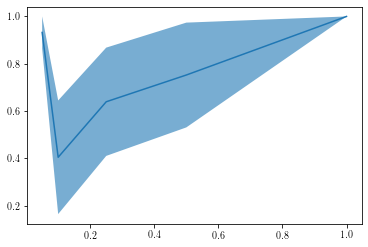

In [189]:
plt.plot(bin_widths, np.mean(p_values, axis = 1))
plt.fill_between(bin_widths, np.mean(p_values, axis = 1)-np.std(p_values, axis = 1),
        np.mean(p_values, axis = 1)+np.std(p_values, axis = 1), alpha = 0.6)

In [10]:
def sampler(energy, weights, bin_width, n_bins_i, phi_k, n = 25000000):
    samples = choices(energy, weights, k = n)
    samples = np.array(samples)
    samples_sorted = np.sort(samples)
    samples_low = samples_sorted[:np.where(samples_sorted < 20)[0][-1]]
    y, bins = np.histogram(samples_low, bins = [bin_width*k for k in range(n_bins_i+1)], density = True)
    x = (bins[1:] + bins[:-1])/2
    ks, p = st.ks_2samp(y - emitted_spectrum_nubar_e(x, phi_k)/simps(emitted_spectrum_nubar_e(x, phi_k), x),
                y - emitted_spectrum_nubar_e(x, 0)/simps(emitted_spectrum_nubar_e(x, 0), x))
    medo = np.median(y - emitted_spectrum_nubar_e(x, phi_k)/simps(emitted_spectrum_nubar_e(x, phi_k), x))
    meds = np.median(y - emitted_spectrum_nubar_e(x, 0)/simps(emitted_spectrum_nubar_e(x, 0), x))
    return medo, meds, p

In [11]:
def sampler_detec(energy, weights, bin_width, n_bins_i, phi_k, n = 25000000):
    samples = choices(energy, weights, k = n)
    samples = np.array(samples)
    samples_sorted = np.sort(samples)
    samples_low = samples_sorted[:np.where(samples_sorted < 20)[0][-1]]
    y, bins = np.histogram(samples_low, bins = [bin_width*k for k in range(n_bins_i+1)], density = True)
    x = (bins[1:] + bins[:-1])/2
    ks, p = st.ks_2samp(y - dtc.detection_spectra(x, 1e53, flavor = 'nubar_e', detector = 'Hyper-k', hierarchy = 'normal', distance = 10, phi = phi_k)/simps(dtc.detection_spectra(x, 1e53, flavor = 'nubar_e', detector = 'Hyper-k', hierarchy = 'normal', distance = 10, phi = phi_k), x),
                y - dtc.detection_spectra(x, 1e53, flavor = 'nubar_e', detector = 'Hyper-k', hierarchy = 'normal', distance = 10, phi = 0)/simps(dtc.detection_spectra(x, 1e53, flavor = 'nubar_e', detector = 'Hyper-k', hierarchy = 'normal', distance = 10, phi = 0), x))
    medo = np.median(y - dtc.detection_spectra(x, 1e53, flavor = 'nubar_e', detector = 'Hyper-k', hierarchy = 'normal', distance = 10, phi = phi_k)/simps(dtc.detection_spectra(x, 1e53, flavor = 'nubar_e', detector = 'Hyper-k', hierarchy = 'normal', distance = 10, phi = phi_k), x))
    meds = np.median(y - dtc.detection_spectra(x, 1e53, flavor = 'nubar_e', detector = 'Hyper-k', hierarchy = 'normal', distance = 10, phi = 0)/simps(dtc.detection_spectra(x, 1e53, flavor = 'nubar_e', detector = 'Hyper-k', hierarchy = 'normal', distance = 10, phi = 0), x))
    return medo, meds, p

In [61]:
bin_widths = [1,0.5,0.25,0.1,0.05,0.01] # MeV
n_binss = [20,40,80,200,400,2000]
n_angles = 30
phi = np.linspace(0, np.pi/2, n_angles)
energy = np.linspace(0.001, 100, 20000000)
n_detections = 30000000

final_p_values = {}
final_median_osc = {}
final_median_stand = {}
final_median_ratio = {}
for l in [0,1,2,3,4]:
    for k in tqdm(range(n_angles)):
        p_values = []
        median_osc = []
        median_stand = []
        weights = emitted_spectrum_nubar_e(energy, phi[k])
        phi_k = phi[k]
        # weights = dtc.detection_spectra(energy, 1e53, flavor = 'nubar_e', detector = 'Hyper-k',
        #             hierarchy = 'normal', distance = 10, phi = phi_k)/simps(dtc.detection_spectra(energy, 1e53, flavor = 'nubar_e', detector = 'Hyper-k',
        #             hierarchy = 'normal', distance = 10, phi = phi_k))
        for i in range(len(bin_widths)):
            bin_width = bin_widths[i]
            n_bins_i = n_binss[i]
            # print(f'Bin width: {bin_widths[i]} MeV')
            # for j in range(40):
            # test = Parallel(n_jobs=6)(delayed(sampler)(energy, weights, bin_width, n_bins_i, phi_k, 200000) for l in range(40))
            medo, meds, p = sampler(energy, weights, bin_width, n_bins_i, phi_k, n_detections)
            # medo, meds, p = sampler_detec(energy, weights, bin_width, n_bins_i, phi_k, 40000000)
            # medo, meds, p = sampler(energy, weights, 2000)
            # median_osc.append(np.array(test)[:,0])
            # median_stand.append(np.array(test)[:,1])
            # p_values.append(np.array(test)[:,2])
            median_osc.append(medo)
            median_stand.append(meds)
            p_values.append(p)
        final_p_values[f'phi = {phi[k]:.2f}'] = np.array(p_values)
        final_median_osc[f'phi = {phi[k]:.2f}'] = np.array(median_osc)
        final_median_stand[f'phi = {phi[k]:.2f}'] = np.array(median_stand)
        final_median_ratio[f'phi = {phi[k]:.2f}'] = np.array(median_osc)/np.array(median_stand)

    pd.DataFrame(final_p_values).to_csv(f'Results/p_values_Earth_oscillation_angles_{l}_{n_detections}.csv')
    pd.DataFrame(final_median_osc).to_csv(f'Results/Median_error_osc_Earth_oscillation_angles_{l}_{n_detections}.csv')
    pd.DataFrame(final_median_stand).to_csv(f'Results/Median_error_stand_Earth_oscillation_angles_{l}_{n_detections}.csv')
    pd.DataFrame(final_median_ratio).to_csv(f'Results/Median_error_ratio_Earth_oscillation_angles_{l}_{n_detections}.csv')

100%|██████████| 30/30 [8:10:00<00:00, 980.02s/it]    


In [62]:
n_detec = 30000000
df1 = pd.read_csv(f'Results/p_values_Earth_oscillation_angles_0_{n_detec}.csv')
df2 = pd.read_csv(f'Results/p_values_Earth_oscillation_angles_1_{n_detec}.csv')
df3 = pd.read_csv(f'Results/p_values_Earth_oscillation_angles_2_{n_detec}.csv')
df4 = pd.read_csv(f'Results/p_values_Earth_oscillation_angles_3_{n_detec}.csv')
df5 = pd.read_csv(f'Results/p_values_Earth_oscillation_angles_4_{n_detec}.csv')

df1 = df1.drop(columns = ['Unnamed: 0'])
df2 = df2.drop(columns = ['Unnamed: 0'])
df3 = df3.drop(columns = ['Unnamed: 0'])
df4 = df4.drop(columns = ['Unnamed: 0'])
df5 = df5.drop(columns = ['Unnamed: 0'])

df_concat = pd.concat((df1, df2, df3, df4, df5))

In [63]:
means_p_values = np.zeros((n_angles, 6))

for i in range(n_angles):
    for j in range(6):
        if np.mean(df_concat[list(df_concat.keys())[i]][j]) >= 0.5:
            means_p_values[i,j] = np.mean(df_concat[list(df_concat.keys())[i]][j])
        elif 0.1 <= np.mean(df_concat[list(df_concat.keys())[i]][j]) < 0.5:
            means_p_values[i,j] = np.mean(df_concat[list(df_concat.keys())[i]][j])
        elif 0.05 <= np.mean(df_concat[list(df_concat.keys())[i]][j]) < 0.1:
            means_p_values[i,j] = np.mean(df_concat[list(df_concat.keys())[i]][j])
        elif 0.01 <= np.mean(df_concat[list(df_concat.keys())[i]][j]) < 0.05:
            means_p_values[i,j] = np.mean(df_concat[list(df_concat.keys())[i]][j])
        elif 0.001 <= np.mean(df_concat[list(df_concat.keys())[i]][j]) < 0.01:
            means_p_values[i,j] = np.mean(df_concat[list(df_concat.keys())[i]][j])
        elif np.mean(df_concat[list(df_concat.keys())[i]][j]) < 0.001:
            means_p_values[i,j] = np.mean(df_concat[list(df_concat.keys())[i]][j])

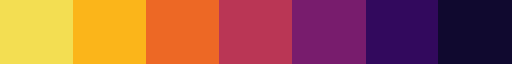

In [64]:
color = 'inferno_r'
division = 11
custom_cmap = mpl.colors.ListedColormap([sns.color_palette(color, division)[0],
                                         sns.color_palette(color, division)[1],
                                         sns.color_palette(color, division)[3],
                                         sns.color_palette(color, division)[5],
                                         sns.color_palette(color, division)[7],
                                         sns.color_palette(color, division)[9],
                                         sns.color_palette(color, division)[10]])

custom_cmap

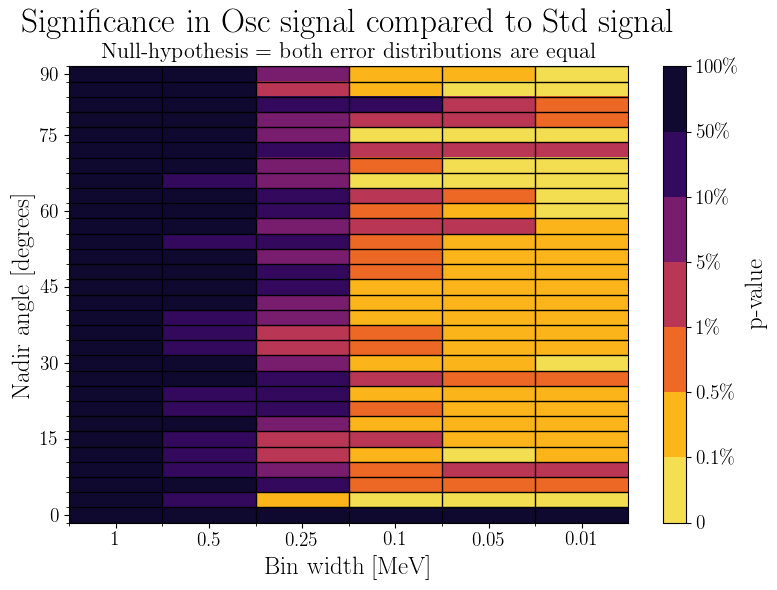

In [65]:
fig, ax = plt.subplots(figsize = (8,6))
bounds=[0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5,1]
norm = mpl.colors.BoundaryNorm(bounds, custom_cmap.N)
# htmp = plt.imshow(pd.DataFrame(final_p_values), vmin = 0)
htmp = plt.imshow(means_p_values, cmap = custom_cmap, interpolation='nearest', origin='lower',
                  aspect='auto', norm = norm)
cbar = plt.colorbar(htmp, ticks = bounds, boundaries = bounds)
cbar.set_label('p-value', fontsize = 18)
cbar.ax.set_yticklabels(['0', '0.1\%', '0.5\%', '1\%', '5\%', '10\%', '50\%', '100\%'], fontsize = 14)
plt.xticks([0,1,2,3,4,5], labels = ['1', '0.5', '0.25', '0.1', '0.05', '0.01'],
          fontsize = 14)
plt.yticks([0, 5, 10, 15, 20, 25, 29],
           labels = ['0', '15', '30', '45', '60', '75', '90'], fontsize = 14)
plt.xlabel('Bin width [MeV]', fontsize = 18)
plt.ylabel('Nadir angle [degrees]', fontsize = 18)

# Minor ticks
ax.set_xticks(np.arange(-0.5, 5, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 31, 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
plt.title('Significance in Osc signal compared to Std signal', fontsize = 24,
         pad = 24)
ax.text(2.5, 30, 'Null-hypothesis = both error distributions are equal', ha = 'center', fontsize = 16)
ax.set_ylim(-0.5, 29.5)
plt.tight_layout()
fig.patch.set_alpha(0.4)
plt.savefig(f'Plots/Significance_signal_{n_detec}.svg', bbox_inches = 'tight')
plt.savefig(f'Plots/Significance_signal_{n_detec}.png', bbox_inches = 'tight')
plt.show()

In [ ]:
plt.plot(bin_widths, np.mean(p_values, axis = 1))
plt.fill_between(bin_widths, np.mean(p_values, axis = 1)-np.std(p_values, axis = 1),
        np.mean(p_values, axis = 1)+np.std(p_values, axis = 1), alpha = 0.6)
plt.ylim(0, 1)
plt.axhline(0.05, ls = '--', lw = 1)

In [ ]:
plt.plot(bin_widths, np.mean(median_osc, axis = 1))
plt.fill_between(bin_widths, np.mean(median_osc, axis = 1)-np.std(median_osc, axis = 1),
        np.mean(median_osc, axis = 1)+np.std(median_osc, axis = 1), alpha = 0.6)

plt.plot(bin_widths, np.mean(median_stand, axis = 1))
plt.fill_between(bin_widths, np.mean(median_stand, axis = 1)-np.std(median_stand, axis = 1),
        np.mean(median_stand, axis = 1)+np.std(median_stand, axis = 1), alpha = 0.6)

In [125]:
for i in tqdm(range(len(phi))):
# i = 100
    fig, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(E, np.abs(emitted_spectrum_nubar_e(E, phi[i])-emitted_spectrum_nubar_e(E, 0, osc=True)),
              color = sns.color_palette('inferno')[0])
    ax[0].set_ylabel(r'$\left| \Delta \right|$',
               fontsize = 22)
    ax[0].set_xlim(0, 50)
    ax[0].set_ylim(0, 4e54)
    ax[0].set_xlabel('Neutrino energy [MeV]', fontsize = 22)
    ax[0].yaxis.offsetText.set_fontsize(16)
    ax[0].set_title(r'Absolute deformation $[\times 10^{54}]$', fontsize = 20)
    ax[0].set_xticklabels([f'{int(ax[0].get_xticks()[j])}' for j in range(6)], fontsize = 16)
    ax[0].set_yticks([0,0.5e54,1e54,1.5e54,2e54,2.5e54,3e54,3.5e54,4e54])
    ax[0].set_yticklabels([0,0.5,1,1.5,2,2.5,3,3.5,4], fontsize = 16)

    ax[1].plot(E, np.abs(emitted_spectrum_nubar_e(E, phi[i])-emitted_spectrum_nubar_e(E, 0, osc=True))/emitted_spectrum_nubar_e(E, 0, osc=True),
              color = sns.color_palette('inferno')[3])
    ax[1].set_ylabel(r'$\left|\frac{\Delta}{F_{\overline{\nu}_e}^{0}}\right|$',
               fontsize = 22)
    ax[1].set_xlim(0, 50)
    ax[1].set_ylim(0, 0.4)
    ax[1].set_xlabel('Neutrino energy [MeV]', fontsize = 22)
    ax[1].set_title('Normalized deformation', fontsize = 20)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    fig.text(0.5, 1.08, r'Deformation ($\Delta$) in $\overline\nu_e$ spectrum for $\phi = {:.2f}$'.format(phi[i]*180/np.pi),
              fontsize = 28, ha = 'center')
    fig.text(0.5, 1, r'$\Delta = F_{\overline{\nu}_e}^\phi - F_{\overline{\nu}_e}^{\phi = 0}$', fontsize = 24,
            ha = 'center')
    plt.tight_layout()
    fig.patch.set_alpha(1)
    plt.savefig(f'/home/pedroc/Documentos/pedro/Mestradives/Simulations/Gifs/Earth_matter_effect_deformation_{i}.png',
                dpi = 300, bbox_inches = 'tight')
    plt.close()

100%|██████████| 200/200 [05:33<00:00,  1.67s/it]


In [37]:
phi = np.linspace(0, np.pi/2, 360)
N = []

for i in tqdm(range(len(phi))):
    N.append(simps(emitted_spectrum_nubar_e(E[1:], phi[i]), E[1:]))
    
N = np.array(N)

100%|██████████| 360/360 [00:00<00:00, 532.98it/s]


In [111]:
size = 360
phi = np.linspace(0, np.pi/2, size)
detections_low_energies = []

for i in tqdm(range(size)):
    detections_low_energies_new = []
    for j in range(100):
        N_new = np.random.poisson(simps(emitted_spectrum_nubar_e(E[1:], phi[i]), E[1:])/(4*np.pi*(10*1e3*3.086e16)**2))
        detections_low_energies_new.append(N_new)
    detections_low_energies.append(detections_low_energies_new)

detections_low_energies = np.array(detections_low_energies)

100%|██████████| 360/360 [01:48<00:00,  3.31it/s]


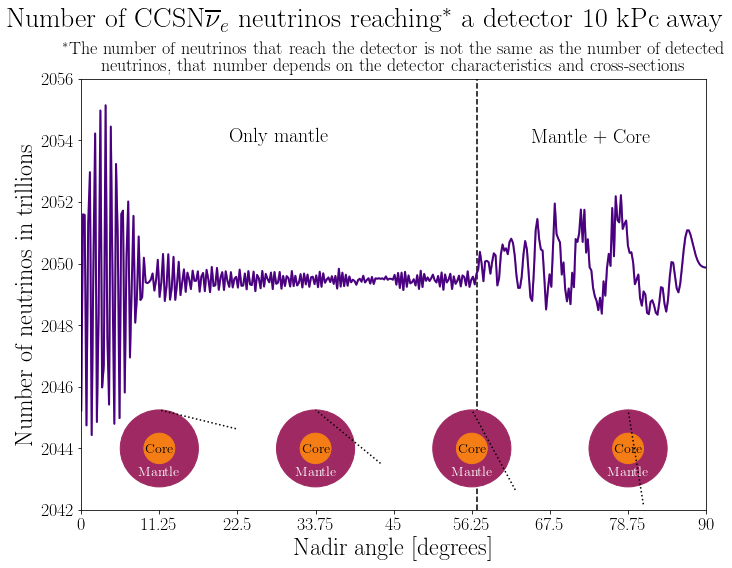

In [119]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(phi, N/(4*np.pi*(10*1e3*3.086e16)**2)/1e12, lw = 2, color = 'indigo')
plt.fill_between(phi, np.percentile(detections_low_energies, 0.5, axis = 1)/1e12,
                 np.percentile(detections_low_energies, 99.5, axis = 1)/1e12, color = 'grey',
                 alpha = 0.5)
plt.suptitle(r'Number of $\mathrm{CCSN}\overline \nu_e$ neutrinos reaching$^*$ a detector 10 kPc away',
             fontsize = 28)
plt.title(r'$^*$The number of neutrinos that reach the detector is not the same as the number of detected'
         '\n'
         'neutrinos, that number depends on the detector characteristics and cross-sections',
          fontsize = 18)
plt.xlim(0, np.pi/2)
plt.xticks([0, np.pi/16, np.pi/8, 3*np.pi/16, np.pi/4, 5*np.pi/16, 3*np.pi/8, 7*np.pi/16, np.pi/2],
           labels = [0, 11.25, 22.5, 33.75, 45, 56.25, 67.5, 78.75, 90], fontsize = 18)
plt.xlabel('Nadir angle [degrees]', fontsize = 24)
plt.yticks(fontsize = 18)
# plt.yticks([7.85e9, 7.9e9, 7.95e9, 8e9, 8.05e9, 8.1e9, 8.15e9],
#            labels = [7.85, 7.9, 7.95, 8, 8.05, 8.1, 8.15], fontsize = 16)
y_up = 2056
y_down = 2042
plt.ylim(y_down, y_up)
plt.ylabel('Number of neutrinos in trillions', fontsize = 24)
plt.axvline(0.9947, lw = 1.5, ls = '--', color = 'black', zorder = 0)
plt.text(0.9947/2, y_up*0.999, 'Only mantle', fontsize = 20, ha = 'center')
plt.text(0.9947 + (np.pi/2 - 0.9947)/2, y_up*0.999, 'Mantle + Core', fontsize = 20, ha = 'center')

center_x = np.array([11.25, 33.75, 56.25, 78.75])*np.pi/180
for i in range(4):
    center_y = 2044
    r_big = (y_up-y_down)*(10/8)/7
    circ1 = mpl.patches.Ellipse((center_x[i], center_y), np.pi/16, r_big, fill = True, color = sns.color_palette('inferno')[2])
    circ2 = mpl.patches.Ellipse((center_x[i], center_y), np.pi/16*0.395, r_big*0.395, fill = True, color = sns.color_palette('inferno')[4])
    ax.add_patch(circ1)
    ax.add_patch(circ2)
    plt.plot([center_x[i] + (np.pi/16)*np.cos(center_x[i]), center_x[i]],
             [center_y + r_big/2 - r_big*np.sin(center_x[i])*1.25, center_y + r_big/2],
         lw = 1.5, ls = 'dotted', color = 'black')
    plt.text(center_x[i], center_y*0.99955, 'Mantle', fontsize = 14, color = 'white', ha = 'center')
    plt.text(center_x[i], center_y*0.99992, 'Core', fontsize = 14, color = 'black', ha = 'center')

fig.patch.set_alpha(0)
for ax in fig.axes:
    ax.patch.set_alpha(0.5)
plt.tight_layout()
# plt.savefig('Plots/Earth_matter_effect_nubar_e_total.svg',
#            dpi = 300, bbox_inches = 'tight')

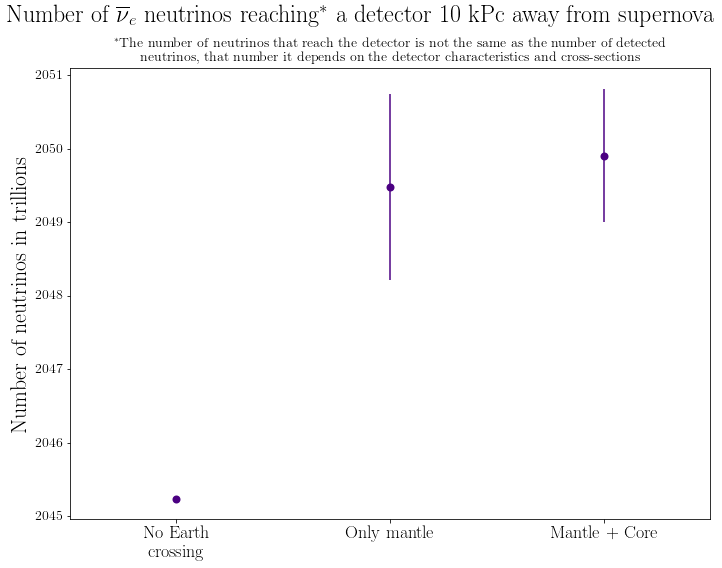

In [59]:
mean_mantle = np.mean(N[:np.where(phi > 0.9947)[0][0]][1:]/(4*np.pi*(10*1e3*3.086e+16)**2)/1e12)
std_mantle = np.std(N[:np.where(phi > 0.9947)[0][0]][1:]/(4*np.pi*(10*1e3*3.086e+16)**2)/1e12)
mean_mantle_core = np.mean(N[np.where(phi > 0.9947)[0][0]:]/(4*np.pi*(10*1e3*3.086e+16)**2)/1e12)
std_mantle_core = np.std(N[np.where(phi > 0.9947)[0][0]:]/(4*np.pi*(10*1e3*3.086e+16)**2)/1e12)

fig, ax = plt.subplots(figsize=(10,8))
plt.scatter([0, 1, 2], [N[0]/(4*np.pi*(10*1e3*3.086e+16)**2)/1e12, mean_mantle, mean_mantle_core],
            lw = 2, color = 'indigo')
plt.vlines([1,2], [mean_mantle-std_mantle, mean_mantle_core -std_mantle_core ],
           [mean_mantle+std_mantle, mean_mantle_core +std_mantle_core ], color = 'indigo')
plt.suptitle(r'Number of $\overline \nu_e$ neutrinos reaching$^*$ a detector 10 kPc away from supernova', fontsize = 24)
plt.title(r'$^*$The number of neutrinos that reach the detector is not the same as the number of detected'
         '\n'
         'neutrinos, that number it depends on the detector characteristics and cross-sections',
          fontsize = 14)
# plt.xlim(0, np.pi/2)
plt.xticks([0, 1, 2], labels = ['No Earth'
                                '\n'
                                'crossing', 'Only mantle', 'Mantle + Core'], fontsize = 18)
# plt.xlabel('Nadir angle [degrees]', fontsize = 22)
plt.yticks(fontsize = 14)
# plt.ylim(7.85e9, 8.05e9)
plt.xlim(-0.5, 2.5)
ax.yaxis.offsetText.set_fontsize(0)
plt.ylabel('Number of neutrinos in trillions', fontsize = 22)

center_x = np.array([0, 1, 2])
# for i in range(3):
#     center_y = 7.92e9
#     circ1 = mpl.patches.Ellipse((center_x[i], center_y), 0.3, 2e7*1.25, fill = True, color = sns.color_palette('inferno')[2])
#     circ2 = mpl.patches.Ellipse((center_x[i], center_y), 0.3*0.395, 2e7*1.25*0.395, fill = True, color = sns.color_palette('inferno')[4])
#     ax.add_patch(circ1)
#     ax.add_patch(circ2)
#     plt.text(center_x[i], 7.91e9, 'Mantle', fontsize = 12, color = 'white', ha = 'center')
#     plt.text(center_x[i], 7.917e9, 'Core', fontsize = 12, color = 'black', ha = 'center')
    
# plt.hlines(center_y + 2e7*1.25/2, 0.7, 1.3, lw = 1.5, ls = 'dotted', color = 'black')
# plt.plot([center_x[1] + 0.3*np.cos(0.9947), center_x[1]],
#          [center_y - 2e7*np.sin(0.9947), center_y+2e7*1.25/2], lw = 1.5, ls = 'dotted',
#          color = 'black')
# plt.plot([center_x[1], center_x[1] - 0.3*np.cos(0.9947)],
#          [center_y+2e7*1.25/2, center_y - 2e7*np.sin(0.9947)], lw = 1.5, ls = 'dotted',
#          color = 'black')

# plt.hlines(center_y + 2e7*1.25/2, -0.3, 0.3, lw = 1.5, ls = 'dotted', color = 'black')
# plt.plot([center_x[2] + 0.3*np.cos(0.9947), center_x[2]],
#          [center_y - 2e7*np.sin(0.9947), center_y+2e7*1.25/2], lw = 1.5, ls = 'dotted',
#          color = 'black')
# plt.plot([center_x[2], center_x[2] - 0.3*np.cos(0.9947)],
#          [center_y+2e7*1.25/2, center_y - 2e7*np.sin(0.9947)], lw = 1.5, ls = 'dotted',
#          color = 'black')
# plt.hlines(center_y + 2e7*1.25/2, 1.7, 2.3, lw = 1.5, ls = 'dotted', color = 'black')

fig.patch.set_alpha(1)
plt.tight_layout()
# plt.savefig('Earth_matter_effect_nubar_e_total_Earth_paths.svg',
#            dpi = 300, bbox_inches = 'tight')

### Detector size and distance for a given number of events

In [26]:
def square(x, a, b):
    return a * x**2 + b

In [27]:
x = np.linspace(1e-3, 100, 100000)
E_tot = 5e52
res = 0.05

cs = []
final_possible_targets_real = []
final_possible_distances_real = []
for k in range(4):
    possible_targets = []
    possible_distances = []
    for i in tqdm(range(100)):
        target = 5e33*(i+1)
        for j in range(100):
            d = 10 - 0.1*j
            N_expected_ebar = np.round(simps(dtc.detection_spectra(x, E_tot, 'nubar_e', 'Hyper-k',
                                                               hierarchy='normal', distance = d,
                                                               phi = 0, custom_size = True,
                                                               target_particles = target), x), 0)
            if N_expected_ebar < (k+1)*1e7:
                pass
            else:
                # print(d)
                possible_targets.append(target)
                possible_distances.append(d)
                break
                
    final_possible_distances = []
    for distance in possible_distances:
        if distance not in final_possible_distances:
            final_possible_distances.append(distance)
            
    final_possible_distances_real.append(final_possible_distances)
            
    final_possible_targets = []
    for l in range(len(final_possible_distances)):
        candidates = []
        indexes = np.where(np.array(possible_distances) == final_possible_distances[l])[0]
        for m in range(len(indexes)):
            candidates.append(possible_targets[indexes[m]])
        final_possible_targets.append(np.min(candidates))
        
    final_possible_targets_real.append(final_possible_targets)
        
    c, cov = curve_fit(square, final_possible_distances, final_possible_targets, p0 = (1e30, 1e30))
    cs.append(c)

100%|██████████| 100/100 [16:12<00:00,  9.73s/it]


In [59]:
final_possible_distances = []
for distance in possible_distances:
    if distance not in final_possible_distances:
        final_possible_distances.append(distance)

In [101]:
final_possible_targets = []
for i in range(len(final_possible_distances)):
    candidates = []
    indexes = np.where(np.array(possible_distances) == final_possible_distances[i])[0]
    for k in range(len(indexes)):
        candidates.append(possible_targets[indexes[k]])
    final_possible_targets.append(np.min(candidates))

In [131]:
def square(x, a, b):
    return a * x**2 + b

c, cov = curve_fit(square, final_possible_distances, final_possible_targets, p0 = (1e30, 1e30))

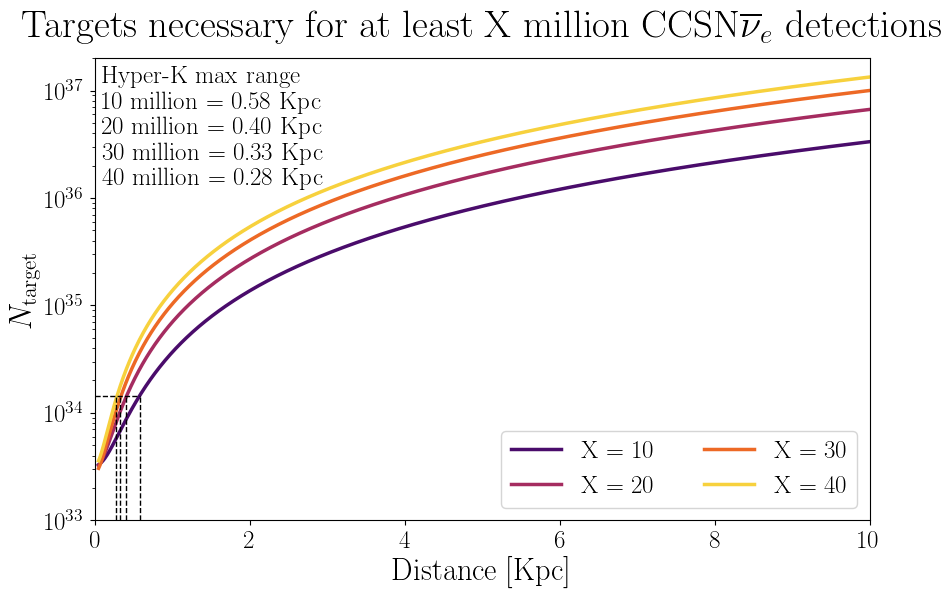

In [60]:
ds = np.linspace(0.05, 10, 1000)
fig, ax = plt.subplots(figsize=(10,6))
# plt.scatter(final_possible_distances, final_possible_targets)
plt.plot(ds, square(np.array(ds), cs[0][0], cs[0][1]), lw = 2.5, color = sns.color_palette('inferno',8)[1],
        label = 'X = 10')
plt.plot(ds, square(np.array(ds), cs[1][0], cs[1][1]), lw = 2.5, color = sns.color_palette('inferno',8)[3],
        label = 'X = 20')
plt.plot(ds, square(np.array(ds), cs[2][0], cs[2][1]), lw = 2.5, color = sns.color_palette('inferno',8)[5],
        label = 'X = 30')
plt.plot(ds, square(np.array(ds), cs[3][0], cs[3][1]), lw = 2.5, color = sns.color_palette('inferno',8)[7],
        label = 'X = 40')
plt.yscale('log')
plt.ylabel(r'$N_{\mathrm{target}}$', fontsize = 22)
plt.xlabel(r'Distance [Kpc]', fontsize = 22)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.xlim(0, 10)
plt.ylim(1e33, 2e37)
plt.hlines(1.44405e+34, 0, 0.58, lw = 1, ls = '--', color = 'black')
plt.vlines(0.28, 1e33, 1.44405e+34, lw = 1, ls = '--', color = 'black')
plt.vlines(0.58, 1e33, 1.44405e+34, lw = 1, ls = '--', color = 'black')
plt.vlines(0.33, 1e33, 1.44405e+34, lw = 1, ls = '--', color = 'black')
plt.vlines(0.4, 1e33, 1.44405e+34, lw = 1, ls = '--', color = 'black')
plt.text(0.1, 1.3e36, 'Hyper-K max range'
         '\n'
         '10 million = 0.58 Kpc'
         '\n'
         '20 million = 0.40 Kpc'
         '\n'
         '30 million = 0.33 Kpc'
         '\n'
         '40 million = 0.28 Kpc', fontsize = 18)
plt.title(r'Targets necessary for at least X million CCSN$\overline{\nu}_e$ detections', fontsize = 28,
         pad = 16)
plt.legend(loc='lower right', fontsize = 18, ncol = 2)
fig.patch.set_alpha(0)
for ax in fig.axes:
    ax.patch.set_alpha(0.5)
plt.savefig('Plots/Number_of_targets_X_million.svg', dpi = 300, bbox_inches = 'tight')
plt.show()

### Identifiability analysis

#### Degeneracy in angle

In [80]:
x = E[1:]
y = emitted_spectrum_nubar_e(E[1:], np.pi/4)

errors = []
n = 561
angles = np.linspace(0, 90, n)
for angle in tqdm(angles):
    y_new = emitted_spectrum_nubar_e(E[1:], angle*np.pi/180)
    err = 100*np.mean(np.abs(y-y_new)/y)
    errors.append(err)
    
errors = np.array(errors)

100%|██████████| 561/561 [00:01<00:00, 436.57it/s]


(0.0, 90.0)

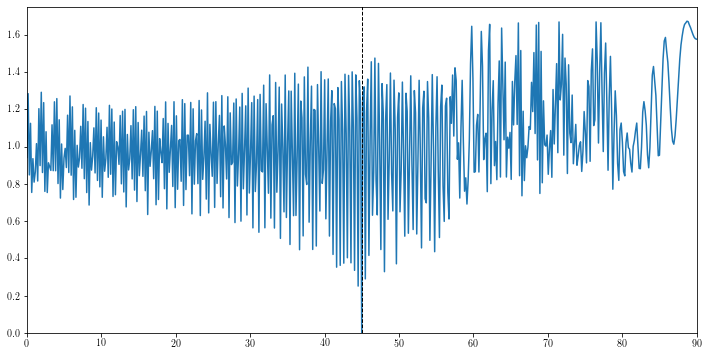

In [81]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(angles, errors)
plt.vlines(180/4, 0, 100, color = 'black', lw = 1, ls = '--')
plt.ylim(0, 1.75)
plt.xlim(angles[0], angles[-1])

In [82]:
x = E[1:]
n = 271
zeros = np.zeros((n,n))
angles = np.linspace(0, 90, n)

for i in tqdm(range(n)):
    angle_new = angles[i]*np.pi/180
    y = emitted_spectrum_nubar_e(E[1:], angle_new)
    errors = []
    for j in range(n):
        y_new = emitted_spectrum_nubar_e(E[1:], angles[j]*np.pi/180)
        err = 100*np.mean(np.abs(y-y_new)/y)
        zeros[i,j] = err

100%|██████████| 271/271 [02:36<00:00,  1.73it/s]


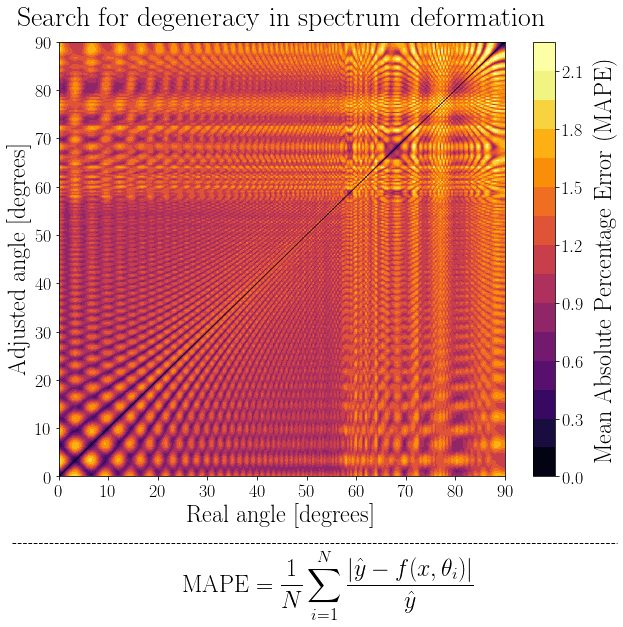

In [101]:
fig, ax = plt.subplots(figsize=(10,8))
graph = plt.contourf(angles, angles, zeros, levels = 20, cmap = 'inferno', vmin = 0, vmax = 2.1)
cb = plt.colorbar(graph, ticks = [0,0.3,0.6,0.9,1.2,1.5,1.8,2.1])
cb.set_label('Mean Absolute Percentage Error (MAPE)', fontsize = 24, labelpad = 10)
cb.ax.tick_params(labelsize=18)
plt.plot(angles, angles, lw = 0.6, color = 'black')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel('Real angle [degrees]', fontsize = 24)
plt.ylabel('Adjusted angle [degrees]', fontsize = 24)
plt.title('Search for degeneracy in spectrum deformation', fontsize = 28, pad = 16)
fig.add_artist(mpl.lines.Line2D([0.06, 0.9], [0.01, 0.01], color = 'black', lw = 1, ls = '--'))
fig.text(0.5, -0.075, r'$\mathrm{MAPE} = \displaystyle \frac{1}{N} \sum_{i=1}^N \frac{|\hat{y} - f(x, \theta_i)|}{\hat{y}}$',
         fontsize = 24, ha = 'center')
fig.patch.set_alpha(0)
# plt.savefig('Plots/Degeneracy_spectrum_distortion_matter_oscillation.svg', dpi = 300, bbox_inches = 'tight')
# plt.savefig('Plots/Degeneracy_spectrum_distortion_matter_oscillation.png', dpi = 300, bbox_inches = 'tight')

In [29]:
def efficiency_sigmoid(x, a, b, c):
    """
    100% em 4.5 MeV e 97% em 4.0 MeV
    Fukuda, S., Fukuda, Y., Hayakawa, T., Ichihara, E., Ishitsuka, M., Itow, Y., ... & Ichikawa, Y. (2003). The super-kamiokande detector.
    Nuclear Instruments and Methods in Physics Research Section A: Accelerators, Spectrometers, Detectors and Associated Equipment, 501(2-3), 418-462.
    """
    eff = a/(1+np.exp(-b*(x-c)))
    return eff

In [30]:
root_folder = '/home/pedroc/Documentos/pedro/Mestradives/xscns/'
channels=['ibd']
#E_cs,nu_e_cs, nu_mu_cs,nu_tau_cs,nu_e_bar_cs,nu_mu_bar_cs,nu_tau_bar_cs=[],[],[],[],[],[],[]
xs_data=[]
columns=['Log(E_cs [Mev])','nu_e_cs[10^-38 cm^2/GeV]', 'nu_mu_cs','nu_tau_cs','nu_e_bar_cs','nu_mu_bar_cs','nu_tau_bar_cs']

for i in range(len(channels)):
    folder=root_folder+'xs_'+channels[i]+'.dat'
    df = pd.read_csv(folder,delim_whitespace=True,skiprows=[0,1], names=columns)
    xs_data.append([])
    for col in columns:
        xs_data[i].append(np.asarray(df[col]))

In [31]:
f = interp1d((10**3)*(10**(xs_data[0][0])),xs_data[0][4]/(10**3), fill_value = 'extrapolate')

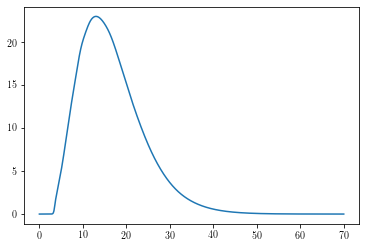

In [32]:
def super_k(x, D, phi):
    y = emitted_spectrum_nubar_e(x, phi)
    n_target = 32e9*6.022e23*2/18.01528
    distance_cm = D*3.086e21 #conversion from kiloparsec to centimeter
    A = n_target/(4 * np.pi * distance_cm**2)
    return y*efficiency_sigmoid(x, 1, 7, 3.5)*A*f(x)*1e-38

plt.plot(x, super_k(x, 10, 0.6))
# plt.plot(x, super_k(x, 10, 0.8))

In [33]:
x = E[1:]
y = super_k(x, 10, np.pi/4)

errors = []
n = 561
angles = np.linspace(0, 90, n)
for angle in tqdm(angles):
    y_new = super_k(x, 10, angle*np.pi/180)
    err = 100*np.nanmean(np.abs(y-y_new)/y)
    errors.append(err)
    
errors = np.array(errors)

100%|██████████| 561/561 [00:01<00:00, 475.70it/s]


(0.0, 90.0)

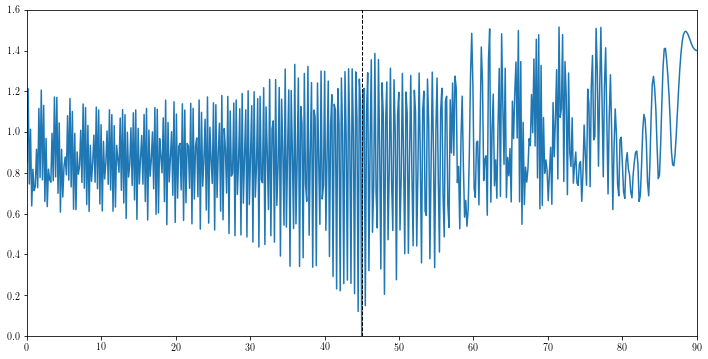

In [35]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(angles, errors)
plt.vlines(180/4, 0, 100, color = 'black', lw = 1, ls = '--')
plt.ylim(0, 1.6)
plt.xlim(angles[0], angles[-1])

In [36]:
x = E[1:]
n = 361
zeros = np.zeros((n,n))
angles = np.linspace(0, 90, n)

for i in tqdm(range(n)):
    angle_new = angles[i]*np.pi/180
    y = super_k(x, 10, angle_new)
    errors = []
    for j in range(n):
        y_new = super_k(x, 10, angles[j]*np.pi/180)
        err = 100*np.nanmean(np.abs(y-y_new)/y)
        zeros[i,j] = err

100%|██████████| 361/361 [04:53<00:00,  1.23it/s]


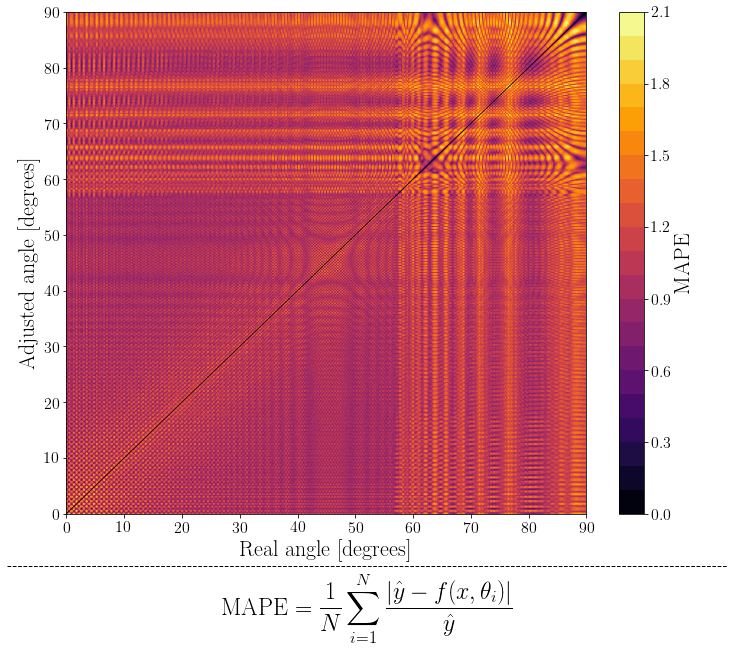

In [37]:
fig, ax = plt.subplots(figsize=(10,8))
graph = plt.contourf(angles, angles, zeros, levels = 20, cmap = 'inferno')
cb = plt.colorbar(graph)
cb.set_label('MAPE', fontsize = 22)
cb.ax.tick_params(labelsize=16)
plt.plot(angles, angles, lw = 0.7, color = 'black')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('Real angle [degrees]', fontsize = 22)
plt.ylabel('Adjusted angle [degrees]', fontsize = 22)
fig.add_artist(mpl.lines.Line2D([0, 1], [0.01, 0.01], color = 'black', lw = 1, ls = '--'))
fig.text(0.5, -0.075, r'$\mathrm{MAPE} = \displaystyle \frac{1}{N} \sum_{i=1}^N \frac{|\hat{y} - f(x, \theta_i)|}{\hat{y}}$',
         fontsize = 24, ha = 'center')
plt.tight_layout()

#### Reconstruction of angle using Least-Squares

In [54]:
c, cov = curve_fit(fitting_oscillation, x, y, p0=(1, np.pi/4, 2, 12, 1), bounds = ([0,0,0,0,0],
                                                                                   [np.inf,np.inf,np.inf,
                                                                                   np.inf,np.inf]))

In [55]:
c

array([3.01271556e-14, 9.77425243e-02, 4.19102596e+00, 1.64233800e+01,
       1.00609761e-02])

In [57]:
cov[1,1]**0.5

3.938965973447156e-12

In [60]:
(c[1] - np.pi/4)/(np.pi/4)

-0.875550352798256

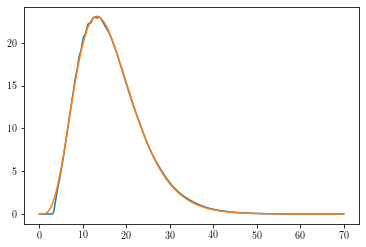

In [56]:
plt.plot(x, y)
plt.plot(x, fitting_oscillation(x, *c))

#### Reconstruction of angle using ABCSMC

In [186]:
#@njit
def rejABC(model, x, y, prior_params, eps, n_sample):
    """
    This is the fitting algorithm, a rejection ABC.
    model: function to be fitted
    x: x data
    y: y data
    prior_params: list of ranges for uniform priors for all free parameters
    eps: selected tolerance
    n_sample: number of samples to be sorted
    """
    n_params = len(prior_params) # Number of model parameters to be fit
    p = np.zeros(n_params+1, dtype=np.float64) # Array of parameters
    post = np.zeros((1,n_params+1)) # Array to build posterior distribution
    
    for i in tqdm(range(n_sample)):
        # Sort parameters according to given priors
        for j in range(n_params):
            p[j] = np.random.uniform(prior_params[j,0], prior_params[j,1])
            while p[j] < 0:
                p[j] = np.random.uniform(prior_params[j,0], prior_params[j,1])
        
        d = np.sqrt(np.sum(((y-model(x, *p[:-1])))**2))/len(x) # Distance = RMSE
        p[-1] = d # Model-data distance
        
        # If the sorted parameters result in a distance smaller than the tolerance
        # they are appended to the posterior distribution
        if (d < eps):
            post = np.concatenate((post, p.reshape((1,n_params+1)))).reshape(len(post)+1, n_params+1)
    
    return post[1:]

# @njit
def sort(n, hist, bins):
    """
    This function sorts numbers from a given histogram using the histogram as
    a probability density function
    n: number of values to be sorted
    hist: k-sized array with height of columns of the normalized histogram
    bins: (l+1)-sized array with values of bins limits
    """
    d = bins[1] - bins[0] # Bin size
    dat = [] # List of sorted random numbers
    
    for i in range(n):
        x = np.random.uniform(0., 1.)
        
        # Conversion of 0-1 random number to number sorted according to the given histogram
        for j in range(len(hist)):
            if (x < np.sum(hist[:j+1])*d):
                dat.append(np.random.uniform(bins[j], bins[j+1]))
                break
    
    return np.array(dat)

# @njit
def smcABC(model, x, y, hist, bins, n_bins, p_std, eps, n_sample, n_max):
    """
    This function continues the fitting after the rejection ABC, it is the
    Sequencial Monte Carlo ABC.
    model: function to be fitted
    x: x data
    y: y data
    hist: heights of the histogram from the past posterior distribution
    bins: limits of bins from the histogram of the past posterior distribution
    n_bins: number of bins used to make a new prior from the last posterior
    p_std: standard deviations of the last posterior distributions, these are used
    to add noise into the sampling process
    eps: tolerance
    n_sample: number of samples to be sorted
    """
    n_mp = len(hist) # Number of model parameters to be fit
    p = np.zeros(n_mp+1, dtype=np.float64) # Array of parameters
    post = np.zeros((1,n_mp+1)) # Array to build posterior distribution
    
    for i in range(n_sample):
        # Sort parameters according to given priors
        for j in range(n_mp):
            # p[j] = np.random.uniform(prior_params[j,0], prior_params[j,1])
            p[j] = sort(1, hist[j], bins[j]) + np.random.normal(scale=p_std[j]/n_bins)
            while p[j] < 0:
                p[j] = sort(1, hist[j], bins[j]) + np.random.normal(scale=p_std[j]/n_bins)
        
        d = np.sqrt(np.sum(((y-model(x, *p[:-1])))**2))/len(x)
        p[-1] = d # Model-data distance
        
        # Check parameters and add sample to posterior distribution
        if (d < eps):
            post = np.concatenate((post, p.reshape((1,n_mp+1)))).reshape(len(post)+1, n_mp+1)
            
        if (len(post) > n_max):
            break
            
    return post[1:]

In [18]:
x = E[1:]
y = emitted_spectrum_nubar_e(E[1:], np.pi/4)

In [37]:
prior_params = np.array([[1e49,4e50],[0,np.pi/2],[0,5],[0,20],[4e52,8e53]], dtype=np.float64)
eps = 2e49
post = rejABC(fitting_oscillation, x, y, prior_params, eps, 100000)

100%|██████████| 100000/100000 [01:36<00:00, 1031.94it/s]


In [38]:
n_bins = 30
repeat = 15
tol = [eps]

for l in tqdm(range(repeat)):
    p = post[np.where(post[:,-1] == np.min(post[:,-1]))[0][0]][:-1]
    p_std = np.std(post[:,:-1], axis=0) # Parameter error as standard deviation of posterior
    
    hist = np.zeros((len(p), n_bins))
    bins = np.zeros((len(p), n_bins+1))
    
    # Define new priors
    for k in range(len(hist)):
        hist[k], bins[k] = np.histogram(post[:, k], n_bins, density=True)
    eps = np.median(post[:,-1])
    tol.append(eps)
    post = smcABC(fitting_oscillation, x, y, hist, bins, n_bins, p_std, eps, 200000,
                  20000)

100%|██████████| 15/15 [14:36<00:00, 58.43s/it]


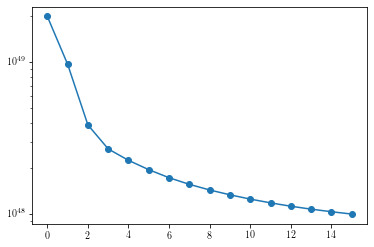

In [39]:
plt.plot(tol)
plt.scatter([i for i in range(len(tol))], tol)
plt.yscale('log')

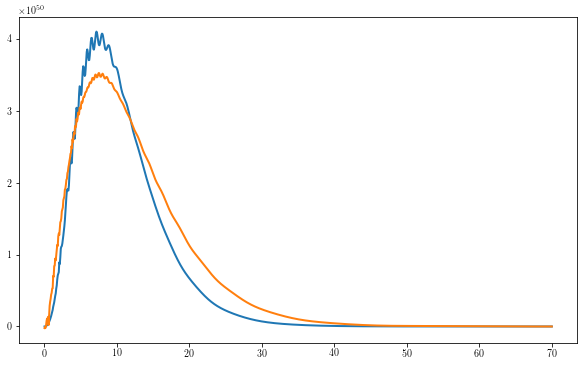

In [90]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x, y, lw = 2)
plt.plot(x, fitting_oscillation(x, *p), lw = 2)
# plt.plot(x, fitting_oscillation(x, 2.58e49, np.pi/4, 2.1, 11, 6e52), lw = 2)

In [41]:
posterior = pd.DataFrame(post)
posterior = posterior.rename(columns={0: r'$A$',
                                      1: r'$\phi$',
                                      2: r'$\alpha$',
                                      3: r'$\left \langle E \right \rangle$',
                                      4: r'$L$',
                                      5: r'Error (RMSE)'})

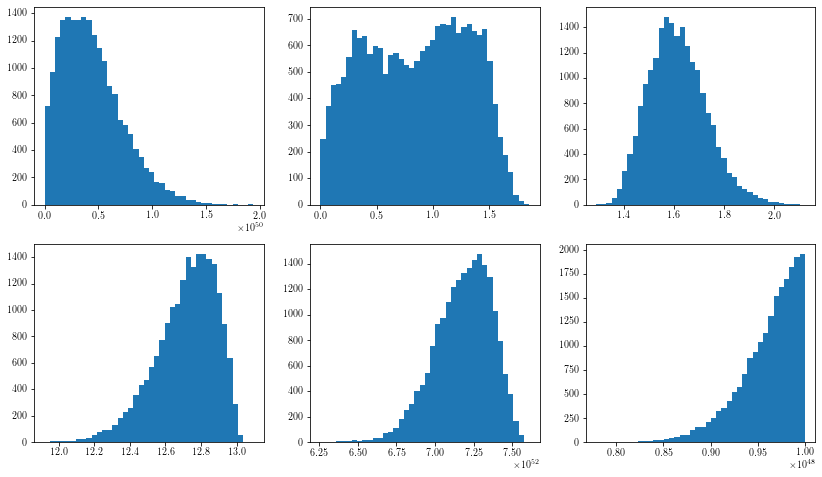

In [42]:
fig, axs = plt.subplots(2, 3, figsize = (14,8))
ax = axs.flatten()
for i in range(6):
    ax[i].hist(post[:,i], bins = 40)
# plt.xlim(0, np.pi/2)
plt.show()

<Figure size 720x576 with 0 Axes>

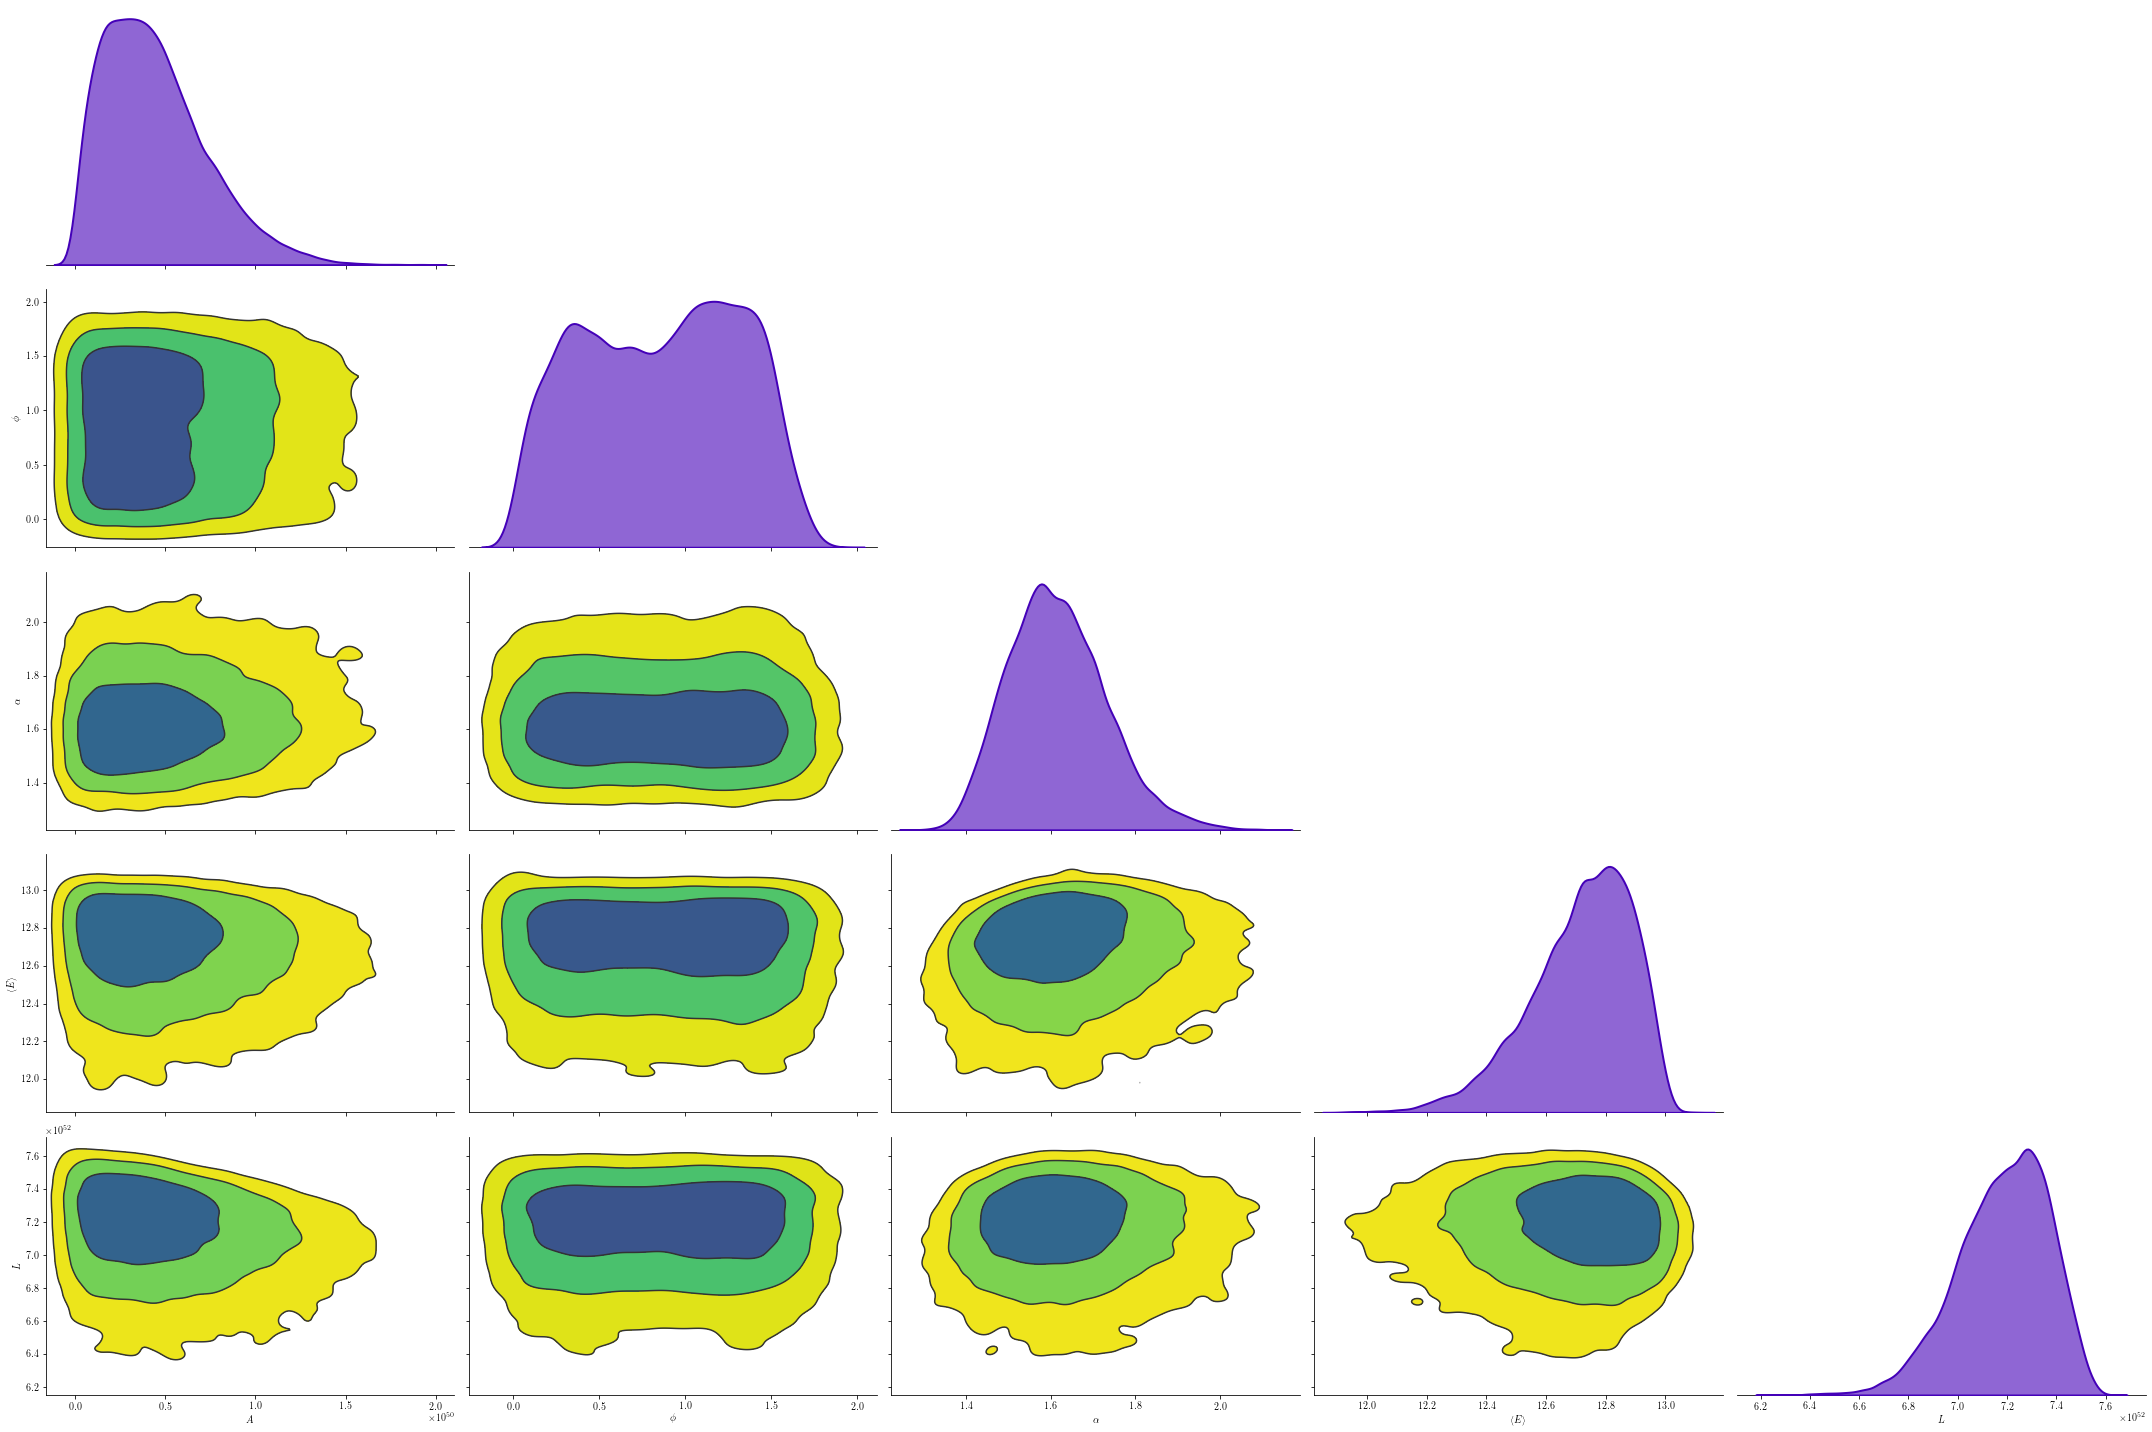

In [89]:
fig = plt.figure(figsize=(10,8))
g = sns.pairplot(data = posterior.drop(columns=['Error (RMSE)']), kind="kde", height=4, aspect=1.5,
                 plot_kws= {'cmap': 'viridis_r',
                            'levels': [0.003,0.05,0.32,1],
                            'fill': True},
                 diag_kws={'color': (68/255,1/255,184/255), 'alpha': 0.6,
                           'linewidth': 2},
                 corner = True)

g.map_lower(sns.kdeplot, levels=[0.003,0.05,0.32,1], color=".2")
# g.axes[1,0].set_ylabel(r'Mean energy $\left \langle E \right \rangle$', fontsize = 18)
# g.axes[2,0].set_ylabel(r'Total luminosity $L$', fontsize = 18)
# g.axes[2,0].set_xlabel(r'Pinch $\alpha$', fontsize = 18)
# g.axes[2,1].set_xlabel(r'Mean energy $\left \langle E \right \rangle$', fontsize = 18)
# g.axes[2,2].set_xlabel(r'Total luminosity $L$', fontsize = 18)
# g.axes[2,0].yaxis.set_tick_params(labelsize = 14)
# g.axes[2,0].xaxis.set_tick_params(labelsize = 14)
# g.axes[1,0].yaxis.set_tick_params(labelsize = 14)
# g.axes[2,1].xaxis.set_tick_params(labelsize = 14)
# g.axes[2,2].xaxis.set_tick_params(labelsize = 14)
# g.axes[2,0].yaxis.offsetText.set_fontsize(14)
# g.axes[2,2].xaxis.offsetText.set_fontsize(14)
# g.axes[0,0].vlines(s_max[0], 0.11825, 0.1198, linestyles = 'dashed', color = 'black')
# g.axes[0,0].text(1.001*s_max[0], 0.11980, f'MAP = {s_max[0]:.5f}', fontsize = 12, ha = 'center')
# g.axes[0,0].set_ylim(0.11825, 0.12025)
# g.axes[2,0].set_xlabel('Growth rate $\lambda$', fontsize = 18)
# g.axes[1,0].set_ylim(14.5, 15)
# g.axes[1,1].set_xlabel('Standard deviation $\sigma$', fontsize = 18)
# g.axes[1,1].text(14.9, 14.98, f'MAP: {s_max[1]:.4f}', fontsize = 12)
# g.axes[1,1].set_xlim(14.5, 15)
# g.axes[1,1].vlines(s_max[1], 14.5, 15, linestyles = 'dashed', color = 'black')

plt.tight_layout()
fig.patch.set_alpha(1)
for ax in fig.axes:
    ax.patch.set_alpha(1)
# plt.savefig('/home/pedroc/Documentos/pedro/Mestradives/Simulations/Neutron_star_radius/pairplot_3_params.png',
#             dpi = 300, bbox_inches = 'tight')

In [57]:
angles = np.linspace(0, np.pi/2, 2500)
amplitudes = np.linspace(1e49, 3e50, 1000)
errors = np.zeros((1000,2500))

for i in tqdm(range(1000)):
    for j in range(2500):
        errors[i,j] = np.sqrt(np.sum(((y-fitting_oscillation(x, amplitudes[i], angles[j], 2.1, 11, 6e52)))**2))/len(x)

100%|██████████| 1000/1000 [43:38<00:00,  2.62s/it]


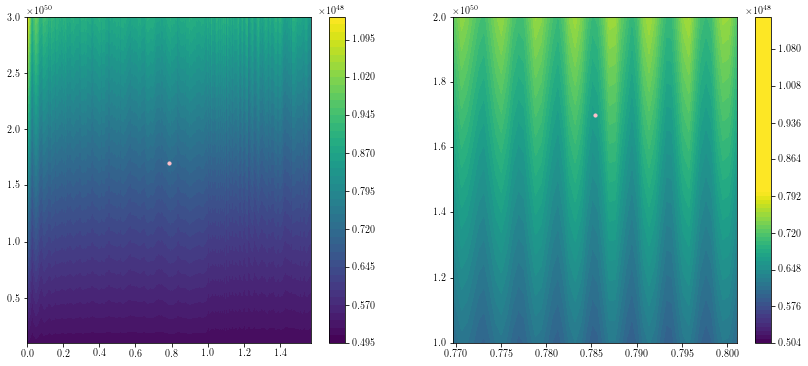

In [61]:
fig, ax = plt.subplots(1, 2, figsize = (14,6))
ct = ax[0].contourf(angles, amplitudes, errors, levels = 60)
ax[0].scatter(np.pi/4, 1.7e50, color = 'pink', s = 10)
plt.colorbar(ct, ax = ax[0])

ct2 = ax[1].contourf(angles, amplitudes, errors, levels = 100, vmax = 8e47)
ax[1].scatter(np.pi/4, 1.7e50, color = 'pink', s = 10)
ax[1].set_ylim(1e50, 2e50)
ax[1].set_xlim(np.pi*0.98/4, np.pi*1.02/4)
plt.colorbar(ct2, ax = ax[1])

In [83]:
size = 3000
angles = np.linspace(0, np.pi/2, size)
amplitude = 1.3e50
errors_one_dim = []

for i in tqdm(range(size)):
    errors_one_dim.append(np.sqrt(np.sum(((y-fitting_oscillation(x, amplitude, angles[i], 2.1, 11, 6e52)))**2))/len(x))

errors_one_dim = np.array(errors_one_dim)

100%|██████████| 3000/3000 [00:02<00:00, 1173.71it/s]


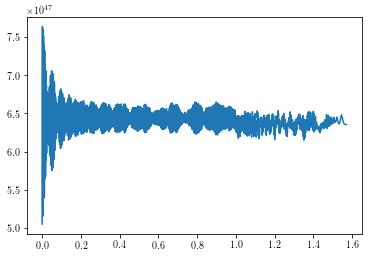

In [88]:
plt.plot(angles, errors_one_dim)
# plt.xlim(0.98*np.pi/4, 1.02*np.pi/4)

### Detection spectrum

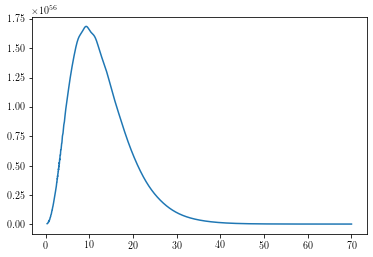

In [60]:
x = E[9:]
y = emitted_spectrum_nubar_e(E[9:], np.pi/4)
plt.plot(x, y)

In [61]:
def efficiency_sigmoid(x, a, b, c):
    """
    100% em 4.5 MeV e 97% em 4.0 MeV
    Fukuda, S., Fukuda, Y., Hayakawa, T., Ichihara, E., Ishitsuka, M., Itow, Y., ... & Ichikawa, Y. (2003). The super-kamiokande detector.
    Nuclear Instruments and Methods in Physics Research Section A: Accelerators, Spectrometers, Detectors and Associated Equipment, 501(2-3), 418-462.
    """
    eff = a/(1+np.exp(-b*(x-c)))
    return eff

In [62]:
root_folder = '/home/pedroc/Documentos/pedro/Mestradives/xscns/'
channels=['ibd']
#E_cs,nu_e_cs, nu_mu_cs,nu_tau_cs,nu_e_bar_cs,nu_mu_bar_cs,nu_tau_bar_cs=[],[],[],[],[],[],[]
xs_data=[]
columns=['Log(E_cs [Mev])','nu_e_cs[10^-38 cm^2/GeV]', 'nu_mu_cs','nu_tau_cs','nu_e_bar_cs','nu_mu_bar_cs','nu_tau_bar_cs']

for i in range(len(channels)):
    folder=root_folder+'xs_'+channels[i]+'.dat'
    df = pd.read_csv(folder,delim_whitespace=True,skiprows=[0,1], names=columns)
    xs_data.append([])
    for col in columns:
        xs_data[i].append(np.asarray(df[col]))

In [63]:
f = interp1d((10**3)*(10**(xs_data[0][0])),xs_data[0][4]/(10**3), fill_value = 'extrapolate')

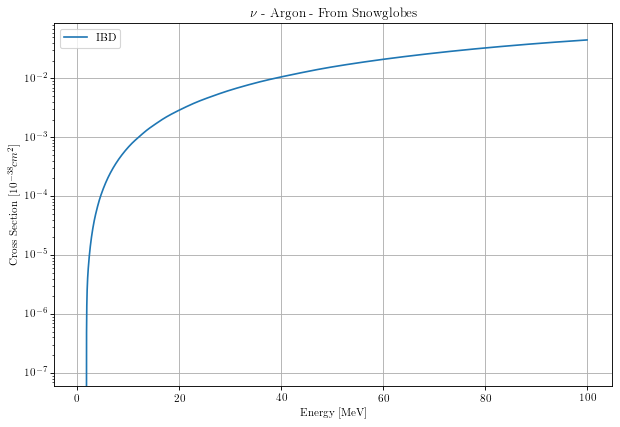

In [64]:
E_vec=np.arange(0,100,0.5)
plt.figure(figsize=(9,6), dpi= 80, facecolor='w', edgecolor='k')
#for i in range(len(channels)):
plt.plot((10**3)*(10**(xs_data[0][0])),xs_data[0][4]*(10**(xs_data[0][0])),label=r'IBD')
# plt.plot(E_vec,XS_nue_Ar_CC(E_vec)*E_vec,label=r'$\nu_e-Ar$ - Kemp')
# plt.plot((10**3)*(10**(xs_data[1][0])),xs_data[1][4]*(10**(xs_data[1][0])),label=r'$\overline{\nu}_e-Ar$')
# plt.plot((10**3)*(10**(xs_data[2][0])),xs_data[2][1]*(10**(xs_data[2][0])),label=r'$\nu_e-e$')
# plt.plot((10**3)*(10**(xs_data[3][0])),xs_data[3][4]*(10**(xs_data[3][0])),label=r'$\overline{\nu}_e-e$')
# plt.plot((10**3)*(10**(xs_data[4][0])),xs_data[4][2]*(10**(xs_data[4][0])),label=r'$\nu_\mu-e$')
# plt.plot((10**3)*(10**(xs_data[5][0])),xs_data[5][5]*(10**(xs_data[5][0])),label=r'$\overline{\nu}_\mu-e$')
# plt.plot((10**3)*(10**(xs_data[6][0])),xs_data[6][1]*(10**(xs_data[6][0])),label=r'$\nu-Ar$ (NC)')
# plt.plot((10**3)*(10**(xs_data[7][0])),xs_data[7][1]*(10**(xs_data[7][0])),label=r'$\nu-Ar$ (coh)')
plt.xlabel("Energy [MeV]")
plt.yscale('log')
plt.ylabel(r"Cross Section $[10^{-38} cm^2]$")
plt.title(r"$\nu$ - Argon - From Snowglobes")
# plt.ylim(10**-7,10)
plt.legend()
plt.grid(True)

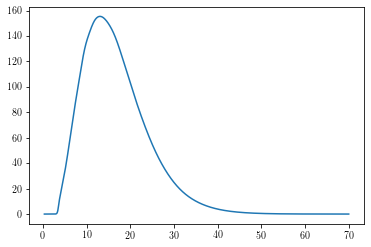

In [73]:
def super_k(x, D, phi):
    y = emitted_spectrum_nubar_e(x, phi)
    n_target = 216e9*6.022e23*2/18.01528
    distance_cm = D*3.086e21 #conversion from kiloparsec to centimeter
    A = n_target/(4 * np.pi * distance_cm**2)
    return y*efficiency_sigmoid(x, 1, 7, 3.5)*A*f(x)*1e-38

plt.plot(x, super_k(x, 10, 0.6))
# plt.plot(x, super_k(x, 10, 0.8))

In [83]:
size = 500
phi = np.linspace(0, np.pi/2, size)
detections_mean = []
detections_std = []
detections_theory = []

for i in tqdm(range(size)):
    detections_new = []
    detections_theory.append(simps(super_k(x, 0.5, phi[i]), x))
    for j in range(100):
        N_new = np.random.poisson(simps(super_k(x, 0.5, phi[i]), x))
        detections_new.append(N_new)
    detections_mean.append(np.mean(detections_new))
    detections_std.append(np.std(detections_new))

detections_mean = np.array(detections_mean)
detections_theory = np.array(detections_theory)
detections_std = np.array(detections_std)

100%|██████████| 500/500 [02:08<00:00,  3.88it/s]


In [84]:
size = 500
phi = np.linspace(0, np.pi/2, size)
x_low_energies = np.linspace(1e-4, 10, 1000)
detections_low_energies_mean = []
detections_low_energies_std = []
detections_low_energies_theory = []

for i in tqdm(range(size)):
    detections_low_energies_new = []
    detections_low_energies_theory.append(simps(super_k(x_low_energies, 0.5, phi[i]), x_low_energies))
    for j in range(100):
        N_new = np.random.poisson(simps(super_k(x_low_energies, 0.5, phi[i]), x_low_energies))
        detections_low_energies_new.append(N_new)
    detections_low_energies_mean.append(np.mean(detections_low_energies_new))
    detections_low_energies_std.append(np.std(detections_low_energies_new))

detections_low_energies_mean = np.array(detections_low_energies_mean)
detections_low_energies_theory = np.array(detections_low_energies_theory)
detections_low_energies_std = np.array(detections_low_energies_std)

100%|██████████| 500/500 [01:26<00:00,  5.81it/s]


(0.0, 1.5707963267948966)

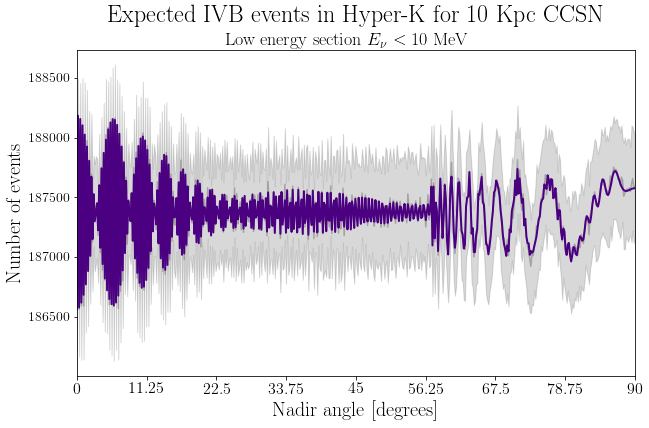

In [85]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(phi, detections_low_energies_mean, color = 'grey', alpha = 0.6)
plt.plot(phi, detections_low_energies_theory, color = 'indigo', lw = 2)
plt.fill_between(phi, detections_low_energies_mean-detections_low_energies_std,
                 detections_low_energies_mean+detections_low_energies_std, color = 'grey', alpha = 0.3)
plt.ylabel('Number of events', fontsize = 20)
plt.xlabel('Nadir angle [degrees]', fontsize = 20)
plt.title('Expected IVB events in Hyper-K for 10 Kpc CCSN', fontsize = 24, pad = 26)
fig.text(0.5, 0.89, r'Low energy section $E_{\nu} < 10$ MeV', fontsize = 18, ha = 'center')
plt.yticks(fontsize = 14)
plt.xticks([0, np.pi/16, np.pi/8, 3*np.pi/16, np.pi/4, 5*np.pi/16, 3*np.pi/8, 7*np.pi/16, np.pi/2],
           labels = [0, 11.25, 22.5, 33.75, 45, 56.25, 67.5, 78.75, 90], fontsize = 16)
plt.xlim(0, np.pi/2)
# plt.ylim(205, 250)
# plt.vlines(0.9947, 205, 250, lw = 1.5, ls = '--', color = 'black', zorder = 0)
# plt.text(0.9947/2, 246, 'Only mantle', fontsize = 16, ha = 'center')
# plt.text(0.9947 + (np.pi/2 - 0.9947)/2, 246, 'Mantle + Core', fontsize = 16, ha = 'center')

# center_x = np.array([11.25, 33.75, 56.25, 78.75])*np.pi/180
# for i in range(4):
#     center_y = 1480
#     circ1 = mpl.patches.Ellipse((center_x[i], center_y), np.pi/16, 4.375*1.667, fill = True, color = sns.color_palette('inferno')[2])
#     circ2 = mpl.patches.Ellipse((center_x[i], center_y), np.pi/16*0.395, 4.375*1.667*0.395, fill = True, color = sns.color_palette('inferno')[4])
#     ax.add_patch(circ1)
#     ax.add_patch(circ2)
#     plt.plot([center_x[i] + (np.pi/16)*np.cos(center_x[i]), center_x[i]],
#              [center_y - 4.375*np.sin(center_x[i]), center_y+4.375*1.667/2],
#          lw = 1.5, ls = 'dotted', color = 'black')
#     plt.text(center_x[i], 1477.2, 'Mantle', fontsize = 12, color = 'white', ha = 'center')
#     plt.text(center_x[i], 1479.5, 'Core', fontsize = 12, color = 'black', ha = 'center')

(0.0, 1.5707963267948966)

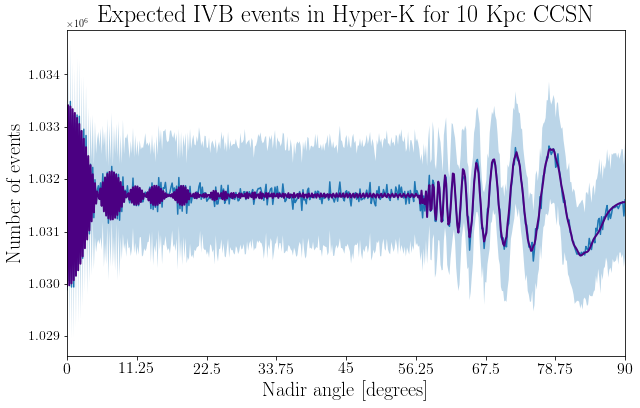

In [86]:
ymin = 1531
ymax = 1535
delta_y = ymax - ymin
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(phi, detections_mean)
plt.plot(phi, detections_theory, color = 'indigo', lw = 2)
plt.fill_between(phi, detections_mean-detections_std, detections_mean+detections_std,
                 alpha = 0.3)
plt.ylabel('Number of events', fontsize = 20)
plt.xlabel('Nadir angle [degrees]', fontsize = 20)
plt.title('Expected IVB events in Hyper-K for 10 Kpc CCSN', fontsize = 24)
plt.yticks(fontsize = 14)
plt.xticks([0, np.pi/16, np.pi/8, 3*np.pi/16, np.pi/4, 5*np.pi/16, 3*np.pi/8, 7*np.pi/16, np.pi/2],
           labels = [0, 11.25, 22.5, 33.75, 45, 56.25, 67.5, 78.75, 90], fontsize = 16)
plt.xlim(0, np.pi/2)
# plt.ylim(ymin, ymax)
# plt.vlines(0.9947, ymin, ymax, lw = 1.5, ls = '--', color = 'black', zorder = 0)
# plt.text(0.9947/2, 0.9995*ymax, 'Only mantle', fontsize = 16, ha = 'center')
# plt.text(0.9947 + (np.pi/2 - 0.9947)/2, 0.9995*ymax, 'Mantle + Core', fontsize = 16, ha = 'center')

# center_x = np.array([11.25, 33.75, 56.25, 78.75])*np.pi/180
# for i in range(4):
#     center_y = 1531.5
#     circ1 = mpl.patches.Ellipse((center_x[i], center_y), np.pi/16, delta_y*1.667/8, fill = True, color = sns.color_palette('inferno')[2])
#     circ2 = mpl.patches.Ellipse((center_x[i], center_y), np.pi/16*0.395, delta_y*1.667*0.395/8, fill = True, color = sns.color_palette('inferno')[4])
#     ax.add_patch(circ1)
#     ax.add_patch(circ2)
#     plt.plot([center_x[i] + (np.pi/16)*np.cos(center_x[i]), center_x[i]],
#              [center_y - delta_y*np.sin(center_x[i])/8, center_y+delta_y*1.667/16],
#          lw = 1.5, ls = 'dotted', color = 'black')
#     plt.text(center_x[i], 1531.2, 'Mantle', fontsize = 12, color = 'white', ha = 'center')
#     plt.text(center_x[i], 1531.45, 'Core', fontsize = 12, color = 'black', ha = 'center')

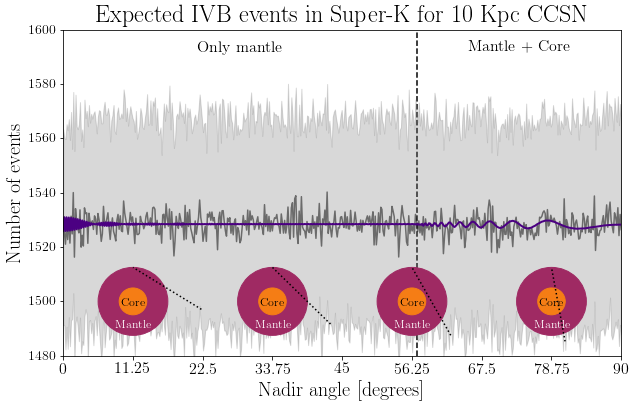

In [70]:
ymin = 1480
ymax = 1600
delta_y = ymax - ymin
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(phi, detections_mean, color = 'black', alpha = 0.5)
plt.plot(phi, detections_theory, color = 'indigo', lw = 2)
plt.fill_between(phi, detections_mean-detections_std, detections_mean+detections_std,
                 color = 'grey', alpha = 0.3)
plt.ylabel('Number of events', fontsize = 20)
plt.xlabel('Nadir angle [degrees]', fontsize = 20)
plt.title('Expected IVB events in Super-K for 10 Kpc CCSN', fontsize = 24)
plt.yticks(fontsize = 14)
plt.xticks([0, np.pi/16, np.pi/8, 3*np.pi/16, np.pi/4, 5*np.pi/16, 3*np.pi/8, 7*np.pi/16, np.pi/2],
           labels = [0, 11.25, 22.5, 33.75, 45, 56.25, 67.5, 78.75, 90], fontsize = 16)
plt.xlim(0, np.pi/2)
plt.ylim(ymin, ymax)
plt.vlines(0.9947, ymin, ymax, lw = 1.5, ls = '--', color = 'black', zorder = 0)
plt.text(0.9947/2, 0.995*ymax, 'Only mantle', fontsize = 16, ha = 'center')
plt.text(0.9947 + (np.pi/2 - 0.9947)/2, 0.995*ymax, 'Mantle + Core', fontsize = 16, ha = 'center')

center_x = np.array([11.25, 33.75, 56.25, 78.75])*np.pi/180
for i in range(4):
    center_y = 1500
    circ1 = mpl.patches.Ellipse((center_x[i], center_y), np.pi/16, delta_y*1.667/8, fill = True, color = sns.color_palette('inferno')[2])
    circ2 = mpl.patches.Ellipse((center_x[i], center_y), np.pi/16*0.395, delta_y*1.667*0.395/8, fill = True, color = sns.color_palette('inferno')[4])
    ax.add_patch(circ1)
    ax.add_patch(circ2)
    plt.plot([center_x[i] + (np.pi/16)*np.cos(center_x[i]), center_x[i]],
             [center_y - delta_y*np.sin(center_x[i])/8, center_y+delta_y*1.667/16],
         lw = 1.5, ls = 'dotted', color = 'black')
    plt.text(center_x[i], 1490, 'Mantle', fontsize = 12, color = 'white', ha = 'center')
    plt.text(center_x[i], 1498, 'Core', fontsize = 12, color = 'black', ha = 'center')

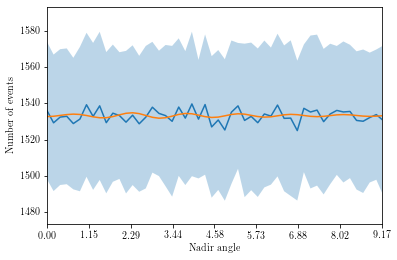

In [103]:
plt.plot(phi, detections_mean)
plt.plot(phi, detections_theory, color = 'C1')
plt.fill_between(phi, detections_mean-detections_std, detections_mean+detections_std,
                 alpha = 0.3)
plt.ylabel('Number of events')
plt.xlabel('Nadir angle')
plt.xlim(0,0.16)
ticks = [0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16]
plt.xticks(ticks, labels = [f'{ticks[i]*180/np.pi:.2f}' for i in range(len(ticks))])
plt.show()